## Estimate weight of long range edges using appropriate penalizations for likelihoods

### Two models: 
1. instantantenous admixture (akin to TreeMix/SpaceMix model) - assume a single long range edge from $s$ to $d$ with some shared portion of the genome $c$. So, then $L^{\dagger_n}_{s,d} = (1-c) \times L^{\dagger_o}_{s,d} + c \times L^{\dagger_o}_{s,s}$

In [4]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# base
import numpy as np
import networkx as nx
from sklearn.impute import SimpleImputer
import pkg_resources
import itertools as it
import math
from scipy.spatial.distance import pdist, squareform
import statsmodels.api as sm
from copy import deepcopy
import pandas as pd
import multiprocessing as mp
from scipy.stats.distributions import chi2
import scipy as sp
from joblib import Parallel, delayed

# viz
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import seaborn as sns

# feems
import sys
sys.path.append('../../')
from feems import SpatialGraph, Viz, Objective
from feems.joint_ver import FEEMSmix_SpatialGraph, FEEMSmix_Objective, loss_wrapper
from feems.sim import setup_graph, setup_graph_long_range, simulate_genotypes, simulate_genotypes_w_admixture
from feems.spatial_graph import query_node_attributes
from feems.utils import cov_to_dist
from feems.objective import comp_mats
from feems.cross_validation import run_cv, run_cvq, run_cv_joint
from feems.helper_funcs import * 

# popgen
# import msprime
# import tskit
import allel

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Helvetica"
})
plt.rcParams['axes.axisbelow'] = True
rng = np.random.default_rng(2022)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Creating a function to calculate Wishart likelihood from a matrix of pairwise resistance distances 

Easier to model $R$ as as function of admixture proportion $c$ instead of modeling $L^\dagger$ as a function of $c$ 

In [26]:
def get_FEEMS_demes_ll_w_c(sp_graph, obj, lrn, c, df=100, sigstar=1):
    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
    # resmat = Rmat + np.reshape(1/sp_graph.q,(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1)) - 2*np.diag(1/sp_graph.q)
    Q1mat = np.ones((sp_graph.n_observed_nodes,1)) @ sp_graph.q_inv_diag.diagonal().reshape(1,-1)
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag
    
    ## sd
    ## resmat[lrn[0][0],lrn[0][1]] = (2*c**2-6*c+4)*Rmat[lrn[0][0],lrn[0][1]] + (c**2-6*c+3)/sp_graph.q[lrn[0][0]] + (c**2+3)/sp_graph.q[lrn[0][1]]
    resmat[lrn[0][0],lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[lrn[0][0],lrn[0][1]] + (1+c)/sp_graph.q[lrn[0][0]] + (1-c)/sp_graph.q[lrn[0][1]]
    resmat[lrn[0][1],lrn[0][0]] = resmat[lrn[0][0],lrn[0][1]]

    ## id
    for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
        resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Rmat[i,lrn[0][0]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[lrn[0][0]]
        resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]

    return sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, df, -sigstar/df*C @ resmat @ C.T), sp.stats.linregress(np.ravel(2*C @ sp_graph.S @ C.T), np.ravel(-C @ resmat @ C.T))[2]**2
    # return sp.stats.wishart.logpdf(-C @ resmat @ C.T, df, 2*C @ sp_graph.S @ C.T) 

def get_FEEMS_demes_nll_w_c(c, sp_graph, obj, lrn, form='element'):
    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T
    
    o = sp_graph.n_observed_nodes

    Rmat = -2*obj.Linv[:o,:o] + np.broadcast_to(np.diag(obj.Linv),(o,o)).T + np.broadcast_to(np.diag(obj.Linv),(o,o)) #np.reshape(np.diag(obj.Linv[:o,:o]),(-1,1)) @ np.ones((1,sp_graph.n_observed_nodes)) + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv[:o,:o]),(1,-1))
    Q1mat = np.broadcast_to(sp_graph.q_inv_diag.diagonal(),(o,o)) #np.ones((sp_graph.n_observed_nodes,1)) @ sp_graph.q_inv_diag.diagonal().reshape(1,-1)
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag     

    if(form!='matrix'):
        ##-----------------using the element-wise formulation----------------------##
        ## sd
        ## resmat[lrn[0][0],lrn[0][1]] = (2*c**2-6*c+4)*Rmat[lrn[0][0],lrn[0][1]] + (c**2-6*c+3)/sp_graph.q[lrn[0][0]] + (c**2+3)/sp_graph.q[lrn[0][1]]
        resmat[lrn[0][0],lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[lrn[0][0],lrn[0][1]] + (1+c)/sp_graph.q[lrn[0][0]] + (1-c)/sp_graph.q[lrn[0][1]]
        resmat[lrn[0][1],lrn[0][0]] = resmat[lrn[0][0],lrn[0][1]]

        ## id
        for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
            resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Rmat[i,lrn[0][0]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[lrn[0][0]]
            resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]

    else:
        ##-----------------using the matrix formulation----------------------##
        BR1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); BR2 = np.zeros_like(BR1); BR3 = np.zeros_like(BR1);

        ## sd
        BR1[lrn[0][0],lrn[0][1]] = 0.5*c**2-1.5*c+1
        BR1[lrn[0][1],lrn[0][0]] = BR1[lrn[0][0],lrn[0][1]]
        ## id
        for i in set(range(BR1.shape[0]))-set([lrn[0][0],lrn[0][1]]):
            #id
            BR1[i,lrn[0][1]] = 1-c
            BR1[lrn[0][1],i] = BR1[i,lrn[0][1]]
            # sd
            BR2[i,lrn[0][1]] = c
            BR2[lrn[0][1],i] = BR2[i,lrn[0][1]]
            # is
            BR3[i,lrn[0][1]] = 0.5*(c**2-c)
            BR3[lrn[0][1],i] = BR3[i,lrn[0][1]]

        BQ1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); 

        BQ1[lrn[0][0],lrn[0][1]] = 1+c
        BQ1[lrn[0][1],lrn[0][0]] = 1-c

        Rismat = np.zeros_like(Rmat); Rsdmat = np.zeros_like(Rmat); Qismat = np.zeros_like(Rmat); Qidmat = np.zeros_like(Rmat)
        for i in set(range(Rmat.shape[0]))-set([lrn[0][0],lrn[0][1]]):
            Rismat[i,lrn[0][1]] = Rmat[i,lrn[0][0]]
            Rismat[lrn[0][1],i] = Rismat[i,lrn[0][1]]

            Rsdmat[i,lrn[0][1]] = Rmat[lrn[0][0],lrn[0][1]]
            Rsdmat[lrn[0][1],i] = Rsdmat[i,lrn[0][1]]

            Qismat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][0]]
            Qismat[lrn[0][1],i] = Qismat[i,lrn[0][1]]

            Qidmat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][1]]
            Qidmat[lrn[0][1],i] = Qidmat[i,lrn[0][1]]

        resmat = np.multiply(BR1,Rmat) + np.multiply(BR3,Rsdmat) + np.multiply(BQ1,Q1mat) + np.multiply(Q1mat.T,BQ1.T) + np.multiply(BR2,Rismat+Qismat-Qidmat) - 2*np.diag(1/sp_graph.q)

    # return resmat
    D = np.ones(sp_graph.n_observed_nodes).reshape(-1,1) @ np.diag(sp_graph.S).reshape(1,-1) + np.diag(sp_graph.S).reshape(-1,1) @ np.ones(sp_graph.n_observed_nodes).reshape(1,-1) - 2*sp_graph.S
    # plt.plot((-C@resmat@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)].T,(-sp_graph.n_snps*C@D@C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,-1)],'bo',label='off-diagonal',alpha=0.6); plt.ylabel(r'$-pC\hat D C^\top$'); plt.xlabel(r'$-C\Delta C^\top$'); 
    # plt.plot(np.diag(-C@resmat@C.T),np.diag(-sp_graph.n_snps*C@D@C.T),'ko',label='diagonal',alpha=0.6); plt.plot(np.diag(-C@resmat@C.T),np.diag(-sp_graph.n_snps*C@D@C.T),'ko',label='diagonal',alpha=0.6); plt.plot((-C@resmat@C.T)[:,lrn[0][1]-1],(-sp_graph.n_snps*C@D@C.T)[:,lrn[0][1]-1],'g*',label='id'); 
    # plt.plot((-C@resmat@C.T)[lrn[0][1]-1,lrn[0][1]-1],(-sp_graph.n_snps*C@D@C.T)[lrn[0][1]-1,lrn[0][1]-1],'r.',label='dd'); plt.legend(); 
    # plt.title(r'$c=${}, $\tau=${}, $\ell=${}, $R^2=${}'.format(c,tau,round(-sp.stats.wishart.logpdf(-sp_graph.n_snps*C @ D @ C.T, sp_graph.n_snps, -C @ resmat @ C.T),2),round(sp.stats.linregress((-C @ resmat @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1)],-sp_graph.n_snps*(C @ D @ C.T)[np.tril_indices(sp_graph.n_observed_nodes-1,)])[2],5))); plt.box(False)
    # return -sp.stats.wishart.logpdf(2*sp_graph.n_snps*C @ sp_graph.S @ C.T, sp_graph.n_snps, -C @ resmat @ C.T)
    return -sp.stats.wishart.logpdf(-sp_graph.n_snps*C @ D @ C.T, sp_graph.n_snps, -C @ resmat @ C.T)

def get_resmat(c, sp_graph, obj, lrn, mode):
    o = sp_graph.n_observed_nodes

    Rmat = -2*obj.Linv[:o,:o] + np.broadcast_to(np.diag(obj.Linv),(o,o)).T + np.broadcast_to(np.diag(obj.Linv),(o,o)) #np.reshape(np.diag(obj.Linv[:o,:o]),(-1,1)) @ np.ones((1,sp_graph.n_observed_nodes)) + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv[:o,:o]),(1,-1))
    Q1mat = np.broadcast_to(sp_graph.q_inv_diag.diagonal(),(o,o)) #np.ones((sp_graph.n_observed_nodes,1)) @ sp_graph.q_inv_diag.diagonal().reshape(1,-1)
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag     

    if mode=='sampled':
        resmat[lrn[0][0],lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[lrn[0][0],lrn[0][1]] + (1+c)/sp_graph.q[lrn[0][0]] + (1-c)/sp_graph.q[lrn[0][1]]
        resmat[lrn[0][1],lrn[0][0]] = resmat[lrn[0][0],lrn[0][1]]

        ## id
        for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
            resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Rmat[i,lrn[0][0]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[lrn[0][0]]
            resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]
    else:
        neighs = list(sp_graph.neighbors(nx.get_node_attributes(sp_graph,'permuted_idx')[lrn[0][0]]))
            # finds the neighboring deme that has samples
        neighs = [s for s in neighs if nx.get_node_attributes(sp_graph,'n_samples')[s]>0]

        R1d = -2*obj.Lpinv[lrn[0][0],lrn[0][1]] + obj.Lpinv[lrn[0][0],lrn[0][0]] + obj.Lpinv[lrn[0][1],lrn[0][1]]
        R1 = np.array(-2*obj.Lpinv[:sp_graph.n_observed_nodes,lrn[0][0]].T + np.diag(obj.Linv) + obj.Lpinv[lrn[0][0],lrn[0][0]])

        # apply this formula only to neighboring sampled demes
        for n in neighs:
            # convert back to appropriate indexing excluding the unsampled demes
            s = [k for k, v in nx.get_node_attributes(sp_graph,'permuted_idx').items() if v==n][0]
            # (1+c)q_s gives an overestimate of the c value (slide 61) ->  keeping it at 1-c
            resmat[s,lrn[0][1]] = Rmat[s,lrn[0][1]] + 0.5*(c**2-c)*R1d + (1-c)/sp_graph.q[s] + (1+c)/sp_graph.q[lrn[0][1]]
            resmat[lrn[0][1],s] = resmat[s,lrn[0][1]]

        proxs = np.argsort([nx.shortest_path_length(sp_graph,source=lrn[0][0],target=d) for d in set(obj.perm_idx[:sp_graph.n_observed_nodes])-set([lrn[0][0]])])[:sp_graph.n_observed_nodes]
        # qprox = np.dot(1/self.sp_graph.q[proxs], (1/R1[0,proxs].T)/np.sum(1/R1[0,proxs]))
        qprox = np.dot(1/sp_graph.q[proxs], (R1[0,proxs]*np.exp(-2*R1[0,proxs]))/np.sum(R1[0,proxs]*np.exp(-2*R1[0,proxs])))
        ## id
        for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]+neighs):
            Ri1 = -2*obj.Lpinv[i,lrn[0][0]] + obj.Lpinv[i,i] + obj.Lpinv[lrn[0][0],lrn[0][0]]
            # resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Ri1 + 0.5*(c**2-c)*R1d + 1/self.sp_graph.q[i] + (1-c)/self.sp_graph.q[opts  ['lre'][0][1]] + c/self.sp_graph.q[proxs]
            # should there be a (1+c)q_d here?
            resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Ri1 + 0.5*(c**2-c)*R1d + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c*qprox
            resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]
  
    return resmat

def get_resmat_mult(c, sp_graph, obj, lrn, mode):
    o = sp_graph.n_observed_nodes

    Rmat = -2*obj.Linv[:o,:o] + np.broadcast_to(np.diag(obj.Linv),(o,o)).T + np.broadcast_to(np.diag(obj.Linv),(o,o)) #np.reshape(np.diag(obj.Linv[:o,:o]),(-1,1)) @ np.ones((1,sp_graph.n_observed_nodes)) + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv[:o,:o]),(1,-1))
    Q1mat = np.broadcast_to(sp_graph.q_inv_diag.diagonal(),(o,o)) #np.ones((sp_graph.n_observed_nodes,1)) @ sp_graph.q_inv_diag.diagonal().reshape(1,-1)
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag     

    if mode=='sampled':
        for ic, ct in enumerate(c):
            resmat[lrn[ic][0],lrn[ic][1]] = (0.5*ct**2-1.5*ct+1)*Rmat[lrn[ic][0],lrn[ic][1]] + (1+ct)/sp_graph.q[lrn[ic][0]] + (1-ct)/sp_graph.q[lrn[ic][1]]
            resmat[lrn[ic][1],lrn[ic][0]] = resmat[lrn[ic][0],lrn[ic][1]]

            ## id
            for i in set(range(sp_graph.n_observed_nodes))-set([lrn[ic][0],lrn[ic][1]]):
                resmat[i,lrn[ic][1]] = (1-ct)*(Rmat[i,lrn[ic][1]]) + ct*Rmat[i,lrn[ic][0]] + 0.5*(ct**2-ct)*Rmat[lrn[ic][0],lrn[ic][1]] + 1/sp_graph.q[i] + (1-ct)/sp_graph.q[lrn[ic][1]] + ct/sp_graph.q[lrn[ic][0]]
                resmat[lrn[ic][1],i] = resmat[i,lrn[ic][1]]
    else:
        neighs = list(sp_graph.neighbors(nx.get_node_attributes(sp_graph,'permuted_idx')[lrn[0][0]]))
            # finds the neighboring deme that has samples
        neighs = [s for s in neighs if nx.get_node_attributes(sp_graph,'n_samples')[s]>0]

        R1d = -2*obj.Lpinv[lrn[0][0],lrn[0][1]] + obj.Lpinv[lrn[0][0],lrn[0][0]] + obj.Lpinv[lrn[0][1],lrn[0][1]]
        R1 = np.array(-2*obj.Lpinv[:sp_graph.n_observed_nodes,lrn[0][0]].T + np.diag(obj.Linv) + obj.Lpinv[lrn[0][0],lrn[0][0]])

        # apply this formula only to neighboring sampled demes
        for n in neighs:
            # convert back to appropriate indexing excluding the unsampled demes
            s = [k for k, v in nx.get_node_attributes(sp_graph,'permuted_idx').items() if v==n][0]
            # (1+c)q_s gives an overestimate of the c value (slide 61) ->  keeping it at 1-c
            resmat[s,lrn[0][1]] = Rmat[s,lrn[0][1]] + 0.5*(c**2-c)*R1d + (1-c)/sp_graph.q[s] + (1+c)/sp_graph.q[lrn[0][1]]
            resmat[lrn[0][1],s] = resmat[s,lrn[0][1]]

        proxs = np.argsort([nx.shortest_path_length(sp_graph,source=lrn[0][0],target=d) for d in set(obj.perm_idx[:sp_graph.n_observed_nodes])-set([lrn[0][0]])])[:sp_graph.n_observed_nodes]
        # qprox = np.dot(1/self.sp_graph.q[proxs], (1/R1[0,proxs].T)/np.sum(1/R1[0,proxs]))
        qprox = np.dot(1/sp_graph.q[proxs], (R1[0,proxs]*np.exp(-2*R1[0,proxs]))/np.sum(R1[0,proxs]*np.exp(-2*R1[0,proxs])))
        ## id
        for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]+neighs):
            Ri1 = -2*obj.Lpinv[i,lrn[0][0]] + obj.Lpinv[i,i] + obj.Lpinv[lrn[0][0],lrn[0][0]]
            # resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Ri1 + 0.5*(c**2-c)*R1d + 1/self.sp_graph.q[i] + (1-c)/self.sp_graph.q[opts  ['lre'][0][1]] + c/self.sp_graph.q[proxs]
            # should there be a (1+c)q_d here?
            resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Ri1 + 0.5*(c**2-c)*R1d + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c*qprox
            resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]
  
    return resmat

In [1356]:
## writing code to pass in gradient wrt c (using scipy.optimize.minimize)
## this is basic code to check if the analytical derivative was found correctly and if I can code it up correctly 
def get_grad_FEEMS_demes_nll_w_c(c, opts):
    sp_graph = opts['sp_graph']; lrn = opts['lrn']

    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*opts['obj'].Linv + np.reshape(np.diag(opts['obj'].Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(opts['obj'].Linv),(1,-1))
    # resmat = Rmat + np.reshape(1/sp_graph.q,(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1)) - 2*np.diag(1/sp_graph.q)
    Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ sp_graph.q_inv_diag.diagonal().reshape(1,-1)).T
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*sp_graph.q_inv_diag
    BR1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); BR2 = np.zeros_like(BR1); BR3 = np.zeros_like(BR1);

    ## sd
    BR1[lrn[0][0],lrn[0][1]] = 0.5*c**2-1.5*c+1
    BR1[lrn[0][1],lrn[0][0]] = BR1[lrn[0][0],lrn[0][1]]
    ## id
    for i in set(range(BR1.shape[0]))-set([lrn[0][0],lrn[0][1]]):
        #id
        BR1[i,lrn[0][1]] = 1-c
        BR1[lrn[0][1],i] = BR1[i,lrn[0][1]]
        # sd
        BR2[i,lrn[0][1]] = c
        BR2[lrn[0][1],i] = BR2[i,lrn[0][1]]
        # is
        BR3[i,lrn[0][1]] = 0.5*(c**2-c)
        BR3[lrn[0][1],i] = BR3[i,lrn[0][1]]

    BQ1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); #BQ2 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); 

    BQ1[lrn[0][0],lrn[0][1]] = 1+c
    BQ1[lrn[0][1],lrn[0][0]] = 1-c

    Rismat = np.zeros_like(Rmat); Rsdmat = np.zeros_like(Rmat); Qismat = np.zeros_like(Rmat); Qidmat = np.zeros_like(Rmat)
    for i in set(range(Rmat.shape[0]))-set([lrn[0][0],lrn[0][1]]):
        Rismat[i,lrn[0][1]] = Rmat[i,lrn[0][0]]
        Rismat[lrn[0][1],i] = Rismat[i,lrn[0][1]]

        Rsdmat[i,lrn[0][1]] = Rmat[lrn[0][0],lrn[0][1]]
        Rsdmat[lrn[0][1],i] = Rsdmat[i,lrn[0][1]]

        Qismat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][0]]
        Qismat[lrn[0][1],i] = Qismat[i,lrn[0][1]]

        Qidmat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][1]]
        Qidmat[lrn[0][1],i] = Qidmat[i,lrn[0][1]]

    resmat = -0.5*(np.multiply(BR1,Rmat) + np.multiply(BR3,Rsdmat) + np.multiply(BQ1,Q1mat) + np.multiply(Q1mat.T,BQ1.T) + np.multiply(BR2,Rismat+Qismat-Qidmat) - 2*np.diag(1/sp_graph.q))

    ## construct derivative vectors
    ## using version from FEEMS appendix
    delldsig = sp_graph.n_snps * (C.T@(np.linalg.inv(C@resmat@C.T)@(C@sp_graph.S@C.T)@np.linalg.inv(C@resmat@C.T)-np.linalg.inv(C@resmat@C.T))@C).reshape(1,-1)
    
    dsigdc = np.zeros((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes))
    dsigdc[lrn[0][0],lrn[0][1]] = (c-1.5)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[lrn[0][0]] - 1/sp_graph.q[lrn[0][1]]
    dsigdc[lrn[0][1],lrn[0][0]] = dsigdc[lrn[0][0],lrn[0][1]]
    for i in set(range(Rmat.shape[0]))-set([lrn[0][0],lrn[0][1]]):
        dsigdc[i,lrn[0][1]] = -Rmat[i,lrn[0][1]] + Rmat[i,lrn[0][0]] + (c-0.5)*Rmat[lrn[0][0],lrn[0][1]] - 1/sp_graph.q[lrn[0][1]] + 1/sp_graph.q[lrn[0][0]]
        dsigdc[lrn[0][1],i] = dsigdc[i,lrn[0][1]]

    # dBR1 = np.zeros((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); dBR2 = np.zeros_like(dBR1); dBR3 = np.zeros_like(dBR1)
    # dBR1[lrn[0][0],lrn[0][1]] = c-1.5
    # dBR1[lrn[0][1],lrn[0][0]] = dBR1[lrn[0][0],lrn[0][1]]
    # ## id
    # for i in set(range(BR1.shape[0]))-set([lrn[0][0],lrn[0][1]]):
    #     #id
    #     dBR1[i,lrn[0][1]] = -1
    #     dBR1[lrn[0][1],i] = dBR1[i,lrn[0][1]]
    #     # sd
    #     dBR2[i,lrn[0][1]] = 1
    #     dBR2[lrn[0][1],i] = dBR2[i,lrn[0][1]]
    #     # is
    #     dBR3[i,lrn[0][1]] = c-0.5
    #     dBR3[lrn[0][1],i] = dBR3[i,lrn[0][1]]

    # dBQ1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); 

    # dBQ1[lrn[0][0],lrn[0][1]] = 1
    # dBQ1[lrn[0][1],lrn[0][0]] = -1

    # dresmat = np.multiply(dBR1,Rmat) + np.multiply(dBR3,Rsdmat) + np.multiply(dBQ1,Q1mat) + np.multiply(Q1mat.T,dBQ1.T) + np.multiply(dBR2,Rismat+Qismat-Qidmat)
    # dsigdc = dresmat.reshape(-1,1)


    return -sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, 1/sp_graph.n_snps*C @ resmat @ C.T)#, np.ravel(delldsig @ dsigdc.reshape(-1,1))[0]

In [3]:
def get_FEEMS_udemes_nll_w_c(c, sp_graph, obj, lrn):
    '''Here, we are modeling the admixture est. framework between an unsampled deme (1) & a sampled deme (d)'''
    # sp_graph = opts['sp_graph']; obj = opts['obj']; lrn = opts['lrn'] # (1, d, s)
    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes] + np.reshape(np.diag(obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes]),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes]),(1,-1))
    Q1mat = np.ones((sp_graph.n_observed_nodes,1)) @ sp_graph.q_inv_diag.diagonal().reshape(1,-1)
    resmat = Rmat + (Q1mat + Q1mat.T); resmat[np.diag_indices(sp_graph.n_observed_nodes)] = 0 #- 2*sp_graph.q_inv_diag

    # need to compute pseudo-inverse of L_{d x d}
    Lpinv = np.linalg.pinv(sp_graph.L.todense())  

    neighs = list(sp_graph.neighbors(nx.get_node_attributes(sp_graph,'permuted_idx')[lrn[0][0]]))
    ## only for sampled neighboring nodes 
    neighs = [s for s in neighs if nx.get_node_attributes(sp_graph,'n_samples')[s]>0]

    R1d = -2*Lpinv[lrn[0][0],lrn[0][1]] + Lpinv[lrn[0][0],lrn[0][0]] + Lpinv[lrn[0][1],lrn[0][1]]

    for s in neighs:
        # convert back to appropriate indexing excluding the unsampled demes
        s = [k for k, v in nx.get_node_attributes(sp_graph,'permuted_idx').items() if v==s][0]
        resmat[s,lrn[0][1]] = Rmat[s,lrn[0][1]] + 0.5*(c**2-c)*R1d + (1-c)/sp_graph.q[s] + (1+c)/sp_graph.q[lrn[0][1]]
        resmat[lrn[0][1],s] = resmat[s,lrn[0][1]]

    # closest sampled deme is the proxy source for the unsampled deme
    proxs = np.argmin([nx.shortest_path_length(sp_graph,source=lrn[0][0],target=d) for d in set([k for k, v in nx.get_node_attributes(sp_graph,'n_samples').items() if v>0])-set([lrn[0][0]])])
    ## id
    for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]+neighs):
        Ri1 = -2*Lpinv[i,lrn[0][0]] + Lpinv[i,i] + Lpinv[lrn[0][0],lrn[0][0]]
        resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Ri1 + 0.5*(c**2-c)*R1d + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[proxs]
        resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]

    return -sp.stats.wishart.logpdf(2*sp_graph.n_snps*C @ sp_graph.S @ C.T, sp_graph.n_snps, -C @ resmat @ C.T)

In [10]:
# obj.lamb = 3.; obj.alpha = 1/sp_graph.w0.mean(); obj.lamb_q = 1.; obj.alpha_q = 1/sp_graph.s2.mean()
# obj.neg_log_lik_c(0,{'lre':[(9,0)],'mode':'sampled'}), obj.joint_neg_log_lik_c(np.r_[np.log(sp_graph.w),np.log(sp_graph.q),sp_graph.c,sp_graph.t],{'lre':[(9,0)]})
# obj.neg_log_lik(), obj.neg_log_lik_c_t([0.55,0.00],{'lre':[(22,57)]}), obj.neg_log_lik_c(0.55,{'lre':[(22,57)],'mode':'sampled'}),
# sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.5,0.001],args={'lre':[(22,57)]},bounds=[(0,1),(0,0.05)],method='Nelder-Mead') #14891
# plt.imshow(obj.Linv-obj_nomu.Linv,cmap='RdBu'); plt.colorbar()
# plt.plot(1/sp_graph.q, 1/sp_graph_nomu.q, 'ko'); plt.axline((0,0),slope=1)
# plt.plot(sp_graph.w, sp_graph_nomu.w, 'ko'); plt.axline((0,0),slope=1)
# obj_nomu.extract_outliers(pthresh=0.01)
# plt.plot(sp_graph.w, np.exp(newres[0][:sp_graph.size()]),'ko')
# newres[1], obj.neg_log_lik_c_t([0.5,0.0],{'lre':[(22,57)]}), obj.neg_log_lik_c(0.5,{'lre':[(22,57)],'mode':'sampled'})
# plt.plot(np.linspace(0,0.05,30),[-obj.neg_log_lik_c_t([0.3,t],{'lre':[(22,57)]}) for t in np.linspace(0,0.05,30)])
# plt.plot(np.linspace(0,0.05,30),[-obj.neg_log_lik_c_t([0.5,t],{'lre':[(22,57)]}) for t in np.linspace(0,0.05,30)])
# plt.plot(np.linspace(0,0.05,30),[-obj.neg_log_lik_c_t([0.7,t],{'lre':[(22,57)]}) for t in np.linspace(0,0.05,30)]); 

In [1251]:
# plt.hist(1/sp_graph.q,bins=10); plt.show(); plt.hist(sp_graph.w,bins=20); plt.show()
# sp_graph.fit(lamb=3., optimize_q='n-dim', lamb_q=1., option='bothct', long_range_edges=[(23,56)])
# newres = sp.optimize.fmin_l_bfgs_b(obj.joint_neg_log_lik_c,x0=np.r_[np.log(obj.sp_graph.w),np.log(obj.sp_graph.s2),obj.sp_graph.c],approx_grad=True,args=[{'lre':[(22,57)]}],factr=1e10,maxiter=1000,maxls=20,bounds=[(-np.inf,np.inf) for _ in range(len(sp_graph.w)+len(sp_graph.s2))]+[(0,1)])
# print(np.exp(newres[0][:sp_graph.size()]), np.exp(newres[0][sp_graph.size():-1]), newres[0][-1])
# newres = sp.optimize.fmin_l_bfgs_b(obj.joint_neg_log_lik_c_t,x0=np.r_[np.log(obj.sp_graph.w),np.log(obj.sp_graph.s2),0.5,1e-2],approx_grad=True,args=[{'lre':[(22,57)]}],factr=1e7,maxiter=1000,maxls=20,bounds=[(-np.inf,np.inf) for _ in range(len(sp_graph.w)+len(sp_graph.s2))]+[(0,1)]+[(0,0.2)])
# print(np.exp(newres[0][:sp_graph.size()]), np.exp(newres[0][sp_graph.size():-2]), newres[0][-2:])
# sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.26,0.00],args=({'lre':[(22,57)]}),method='Nelder-Mead',bounds=[(0,1),(0,0.03)]), sp.optimize.minimize(obj.neg_log_lik_c,x0=0.2,args=({'lre':[(22,57)],'mode':'sampled'}),method='L-BFGS-B',bounds=[(0,1)]), newres[1], obj.neg_log_lik_c_t([0.5,0.001],{'lre':[(22,57)]}),obj.neg_log_lik_c(0.09,{'lre':[(22,57)],'mode':'sampled'}) # 13401
# sp.optimize.minimize(obj.neg_log_lik_c,x0=0.2,args=({'lre':[(22,57)],'mode':'sampled'})), sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.22,1e-4],args=({'lre':[(22,57)]}),method='L-BFGS-B',bounds=[(0,1),(0,0.2)])
# obj.joint_neg_log_lik_c(np.r_[np.log(sp_graph.w),np.log(sp_graph.s2),0.29],{'lre':[(22,57)]})
# obj.joint_neg_log_lik_c_t(np.r_[np.log(sp_graph.w),np.log(sp_graph.s2),0.6,0.01],{'lre':[(22,57)]}) #
# -sp.stats.wishart.logpdf(2*sp_graph.n_snps*C @ sp_graph.S @ C.T, sp_graph.n_snps, -C @ resmat @ C.T), -sp.stats.wishart.logpdf(2*sp_graph.n_snps*C @ sp_graph.S @ C.T, sp_graph.n_snps, -C @ resmat_hao @ C.T)

array([1.17563213, 1.17563213, 1.17563213, 1.17563213, 1.17563213,
       1.17563213, 1.17563213, 1.17563213, 1.17563213, 1.17563213,
       1.17563213, 1.17563213, 1.17563213, 1.17563213, 1.17563213,
       1.17563213, 1.17563213, 1.17563213, 1.17563213, 1.17563213,
       1.17563213, 1.17563213, 1.17563213, 1.17563213, 1.17563213,
       1.17563213, 1.17563213, 1.17563213, 1.17563213, 1.17563213,
       1.17563213, 1.17563213, 1.17563213, 1.17563213, 1.17563213,
       1.17563213, 1.17563213, 1.17563213, 1.17563213, 1.17563213,
       1.17563213, 1.17563213, 1.17563213, 1.17563213, 1.17563213,
       1.17563213, 1.17563213, 1.17563213, 1.17563213, 1.17563213,
       1.17563213, 1.17563213, 1.17563213, 1.17563213, 1.17563213,
       1.17563213, 1.17563213, 1.17563213, 1.17563213, 1.17563213,
       1.17563213, 1.17563213, 1.17563213, 1.17563213, 1.17563213,
       1.17563213, 1.17563213, 1.17563213, 1.17563213, 1.17563213,
       1.17563213, 1.17563213, 1.17563213, 1.17563213, 1.17563

Text(0, 0.5, 'empirical distance')

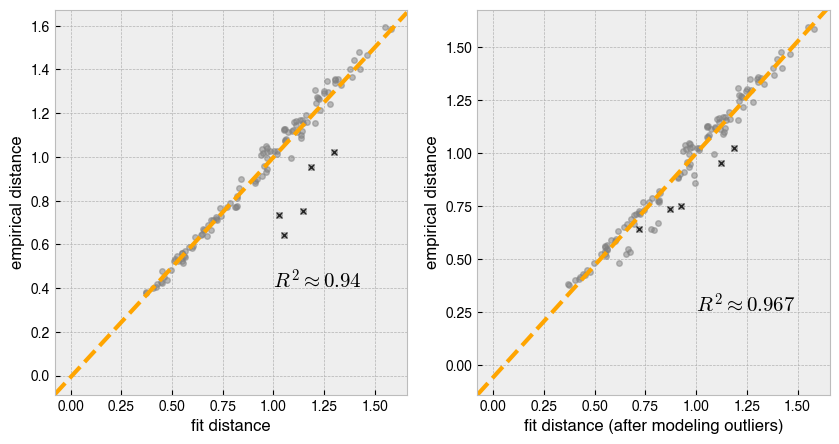

In [59]:
# n_rows, n_columns = 8, 10
# graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1e-2, barrier_w=1e-2, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=4, barrier_endpt=6, n_samples_per_node=15)
# gen_test_2 = simulate_genotypes_w_admixture(graph_def, target_n_snps=800, n_print=700, long_range_nodes=[(22,57),(10,77),(19,63)], admixture_props=[0.5,0.3,0.8], time_of_adm=[1e-6,1e-4,1e-4], n_e=10, dump=False)
# sp_graph = FEEMSmix_SpatialGraph(gen_test_2, coord_def, grid_def, edge_def)
# %time sp_graph.fit(lamb=3., optimize_q='n-dim', lamb_q=1.); obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False); #oldw = sp_graph.w; olds2 = sp_graph.s2
# df = obj.extract_outliers(0.001,verbose=False)
# plt.plot(oldw,np.exp(newres[0][:sp_graph.size()]),'ko',alpha=0.5); plt.axline((1,1),slope=1,color='grey'); plt.xlabel(r'$\hat w$ before joint optimization'); plt.ylabel(r'$\hat w$ after')
# plt.plot(olds2,np.exp(newres[0][sp_graph.size():-2]),'ko',alpha=0.5); plt.axline((1,1),slope=1,color='grey'); plt.plot(olds2[57],np.exp(newres[0][sp_graph.size():-2])[57],'r*'); plt.xlabel(r'$\hat \sigma^2$ before joint optimization'); plt.ylabel(r'$\hat \sigma^2$ after')
# np.exp(newres[0][sp_graph.size():-1])
# fig = plt.figure(dpi=110)
# ax = fig.add_subplot(1, 1, 1)
# v = Viz(ax, sp_graph, projection=ccrs.Mercator(), edge_width=2, abs_max=0.25,
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
# v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=False); v.draw_edge_colorbar()
# sp_graph.fit(lamb=3., optimize_q=None, option='onlyc', long_range_edges=[(23,56)]); sp_graph.c
# sp_graph.q

fig = plt.figure(figsize=(10,5))
plt.subplot(121)
fit_cov, _, emp_cov = comp_mats(obj)
fit_dist = cov_to_dist(fit_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]
emp_dist = cov_to_dist(emp_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]
X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()
muhat, betahat = res.params
# pvals = sp.stats.norm.cdf(np.log(emp_dist)-np.log(fit_dist)-np.mean(np.log(emp_dist)-np.log(fit_dist)), 0, np.std(np.log(emp_dist)-np.log(fit_dist)))
med = np.median(np.log(emp_dist)-np.log(fit_dist))
mad = 1.4826*np.median(np.abs(np.log(emp_dist)-np.log(fit_dist) - med))
mvals = (np.log(emp_dist)-np.log(fit_dist) - med)/mad
plt.plot(fit_dist, emp_dist, 'o', color='k', alpha=0.5, markersize=4); plt.axline((0,muhat), slope=betahat, color='orange', ls='--', lw=3)
plt.plot(fit_dist[mvals<-3], emp_dist[mvals<-3], 'r*', alpha=0.8, markersize=4)
plt.text(1, 0.4, r'$R^2 \approx {}$'.format(np.around(res.rsquared_adj,3)), fontsize=15); plt.xlabel('fit distance'); plt.ylabel('empirical distance'); 

plt.subplot(122)
# resmat = get_resmat_mult([0.5,1,0.3], sp_graph, obj, [(22,57),(19,63),(10,77)], 'sampled')
resmat = get_resmat(0.41, sp_graph, obj, [(27,9)], 'unsampled')
res_dist = np.array(cov_to_dist(-0.5*resmat)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)])[0]
X = sm.add_constant(res_dist.T)
mod = sm.OLS(emp_dist, X)
res = mod.fit()
muhat, betahat = res.params
plt.plot(res_dist.T, emp_dist, 'o', color='k', alpha=0.5, markersize=4); plt.axline((0,muhat), slope=betahat, color='orange', ls='--', lw=3)
plt.plot(res_dist.T[mvals<-3], emp_dist[mvals<-3], 'r*', alpha=0.8, markersize=4)
plt.text(1, 0.25, r'$R^2 \approx {}$'.format(np.around(res.rsquared_adj,3)), fontsize=15); plt.xlabel('fit distance (after modeling outliers)'); plt.ylabel('empirical distance')

# lle, te = get_best_lre(sp_graph, gen_test_2, coord_def, grid_def, edge_def, k=2, top=5, nchoose=100, option='hard')
# defw = sp_graph.w; defq = sp_graph.q
# obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)
# gr = obj.grad_obj 
# sp_graph = Joint_SpatialGraph(gen_test_80, coord_def, grid_def, edge_def)
# sp_graph.fit(lamb=3., optimize_q='n-dim', option='joint', long_range_edges=[(23,56)], c=0.2); #sp_graph.fit(lamb=3., optimize_q='n-dim', option='onlyc', long_range_edges=[(23,56)], c=0.2) 
# jtw = sp_graph.w; jtq = sp_graph.q
# grjt = obj.grad_obj
# plt.plot(defw, jtw, 'ko'); plt.plot(defw,defw,ls='-',color='grey'); plt.xlabel('default weights'); plt.ylabel('weights with $c=0$'); plt.show()
# plt.plot(defq, jtq, 'ko'); plt.plot(defq,defq,ls='-',color='grey'); plt.xlabel('default $q$'); plt.ylabel('$q$ with $c=0$')
# plt.plot(gr, grjt, 'ko'); plt.plot(gr,gr,ls='-',color='grey'); plt.xlabel('gradient of obj (default)'); plt.ylabel('gradient of obj (with $c=0$)')

In [1191]:
# df['log-lik'].sort_values(ascending=False)[:int(0.1*len(df))]
# for it, row in df.loc[topidx].iterrows():
# joint_contour_df = df.loc[topidx]
# joint_contour_df['log-lik'] - joint_df
# sp.stats.chi2.sf(2*joint_df.loc[topidx-1]['log-lik'].values+2*840,1)

# , joint_df.loc[topidx-1], joint_contour_df

,"(source, dest.)",admix. prop.,log-lik,scaled log-lik
62,"(62, 44)",0.465796,-564.090541,0.000000
61,"(61, 44)",0.448088,-564.434590,-0.344048
50,"(50, 44)",0.462440,-564.791752,-0.701211
51,"(51, 44)",0.488632,-565.411566,-1.321025
75,"(75, 44)",0.445050,-566.936991,-2.846449
73,"(73, 44)",0.430625,-567.064544,-2.974003
39,"(38, 44)",0.472408,-567.135059,-3.044518
63,"(63, 44)",0.486544,-567.286584,-3.196042
60,"(60, 44)",0.430167,-567.559407,-3.468865
38,"(37, 44)",0.444639,-567.767285,-3.676744


In [79]:
# sampnodes = np.sort(np.unique(np.random.choice(97,16,replace=False).tolist()+[51,44])).tolist()#[2,14,18,25,31,44,46,51,57,66,74,77]
# sampnodes = [2,4,10,12,14,15,21,28,30,36,44,60,63,66,80,83,89]
# ss = [2*np.random.randint(1,11) if i in sampnodes else 0 for i in range(96)]
# graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=8, n_columns=12, corridor_w=1e-2, barrier_w=1e-3, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=4, barrier_endpt=7, n_samples_per_node=10, option=2, ss=ss)
# gen_test_80 = simulate_genotypes_w_admixture(graph_def, target_n_snps=1000, n_print=500, long_range_nodes=[(51,44)], admixture_props=[0.5], n_e=np.geomspace(1e1,1e4,96), time_of_adm=[1e-7])
# coord = coord_def[list(range(np.sum(ss[:51])//2))+list(range(np.sum(ss[:52])//2,np.sum(ss)//2)),:]
# gen_test = gen_test_80[list(range(np.sum(ss[:51])//2))+list(range(np.sum(ss[:52])//2,np.sum(ss)//2)),:]
# gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==0)[0],1)
# gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==2*gen_test.shape[0])[0],1)
# sp_graph = SpatialGraph(gen_test, coord, grid_def, edge_def)
sp_graph.fit(lamb=.5,optimize_q='1-dim',lamb_q=1.)
obj = Objective(sp_graph); obj.inv(); obj.grad(reg=False)
sp_graph.sequential_fit(lamb=0.5,lamb_q=1.,optimize_q='1-dim',top=5,search_area='radius',opts=3)
# top = obj.extract_outliers(0.25, verbose=True); #obj.inv(); obj.Lpinv = np.linalg.pinv(sp_graph.L.todense()); obj.grad(reg=False)
# df = obj.calc_contour(destid=44,search_area='all',exclude_boundary=False)
# sampnodes = list(np.arange(0,97)[::2])#+[63]
# sampnodes = [2,18,25,31,44,46,57,62,74]
# sampnodes = [2,4,10,12,14,15,20,28,30,36,44,51,57,60,63,66,80,83,86,89]
# sampnodes = np.sort(np.unique(np.random.choice(97,20,replace=False).tolist()+[51,44])).tolist()
# ss = [2*np.random.randint(1,11) if i in sampnodes else 0 for i in range(96)]
# sampnodes = [2,14,18,25,31,44,46,57,62,66]
# np.array(ss)[np.array(sampnodes)]
# graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=8, n_columns=12, corridor_w=1e-2, barrier_w=1e-3, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=4, barrier_endpt=8, option=2, ss=ss)
# foo = lambda c: simulate_genotypes_w_admixture(graph_def, target_n_snps=1000, n_print=800, long_range_nodes=[(51,44)], admixture_props=[0.5], n_e=10**(1+np.random.random(96)*2), time_of_adm=[1e-8])
# gen_test_80 = Parallel(n_jobs=1)(delayed(foo)(0.5) for _ in range(1))
# df = obj.calc_contour(destid=20,search_area='all',exclude_boundary=False)

constant-w/variance fit, converged in 30 iterations, train_loss=-3390.4826801
lambda=0.500, alpha=0.6274, converged in 48 iterations, train_loss=-4292.793
Log-likelihood of initial fit: -696.9

Using a FDR of 0.25:

8 outlier deme pairs found

Putative destination demes:[44]
44    8
Name: dest., dtype: int64

Fitting long range edge to deme 44...
Optimizing likelihood over 15 demes in the graph...done!
Jointly optimizing likelihood over 5 demes in the graph...
0...1...joint estimation converged in 2 iterations!
lambda=0.500, alpha=0.4810, converged in 1 iterations, train_loss=715.274
0...1...joint estimation converged in 2 iterations!
lambda=0.500, alpha=0.4810, converged in 1 iterations, train_loss=716.047
0...1...joint estimation converged in 2 iterations!
lambda=0.500, alpha=0.4810, converged in 1 iterations, train_loss=716.067
0...1...joint estimation converged in 2 iterations!
lambda=0.500, alpha=0.4810, converged in 1 iterations, train_loss=716.368
0...1...joint estimation conver

{0: {'log-lik': -696.9388630616959,
  'emp_dist': array([0.48562057, 0.94687121, 0.9281251 , 0.40578389, 0.55470878,
         0.91069486, 0.28631235, 0.35413911, 0.83930475, 0.34754427,
         0.33723548, 0.26962604, 0.82365083, 0.36710983, 0.18608711,
         1.04720538, 0.99158525, 0.71145722, 1.00326306, 0.92196829,
         0.90795854, 0.50139031, 0.52195698, 0.90169151, 0.5206418 ,
         0.36679696, 0.32517265, 0.99555724, 0.9371809 , 0.89160274,
         0.86418515, 0.89190018, 0.75935961, 0.76140059, 0.97896526,
         0.83619895, 0.45219497, 0.56371611, 0.89052488, 0.39962065,
         0.37368508, 0.36867652, 1.02491296, 0.50569632, 0.88550115,
         0.55089774, 0.56153012, 0.60719951, 0.5153582 , 0.41541541,
         0.39604424, 0.71814658, 0.50053443, 0.60635359, 0.47497514,
         0.57710576, 0.65339688, 0.91607535, 0.55775707, 0.47973988,
         0.45401815, 1.0479941 , 0.60104685, 0.87244294, 0.54214882,
         0.5421608 , 0.5537905 , 0.56247281, 0.82465237

## Function to simulate under the two different schemes (in Parallel)

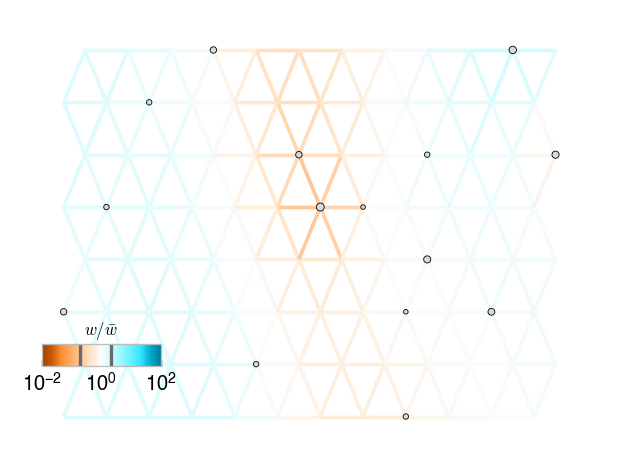

In [911]:
# def sim_var_sparse(nsnps, c, sparsity):
#     sampnodes = np.sort(np.unique(np.random.choice(97,sparsity,replace=False).tolist()+[51,44])).tolist()#[2,14,18,25,31,44,46,51,57,66,74,77]
#     ss = [2*np.random.randint(1,11) if i in sampnodes else 0 for i in range(96)]
#     graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=8, n_columns=12, corridor_w=1e-2, barrier_w=1e-3, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., 
#                                                            barrier_startpt=4, barrier_endpt=7, n_samples_per_node=10, option=2, ss=ss)
#     n_e = 10**(1+np.random.random(96)*3)
#     gen_test_80 = simulate_genotypes_w_admixture(graph_def, target_n_snps=nsnps, n_print=int(0.8*nsnps), long_range_nodes=[(51,44)], admixture_props=[c], n_e=n_e, time_of_adm=[1e-7])

#     return [gen_test_80, ss, n_e, coord_def]
# _, coord_def, grid_def, edge_def = setup_graph(n_rows=8, n_columns=12, corridor_w=1e-2, barrier_w=1e-3, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., 
#                                                        barrier_startpt=4, barrier_endpt=7, n_samples_per_node=10, option=2, ss=ss)
# sims = Parallel(n_jobs=16)(delayed(sim_var_sparse)(1000,0.5,16) for _ in range(16))
# top = obj.extract_outliers(0.25)
# results.to_csv("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/sparse_samp.csv")
# import pickle 
# with open("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/sparse_samp_sims.pkl", 'wb') as fp:
#     pickle.dump(sims, fp)
# with open('/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/sparse_samp_sims.pkl', 'rb') as fp:
#     sims = pickle.load(fp)
# results = pd.read_csv("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/sparse_samp.csv", index_col=0)

# rep = 6
# coord = sims[rep][3][list(range(np.sum(sims[rep][1][:51])//2))+list(range(np.sum(sims[rep][1][:52])//2,np.sum(sims[rep][1])//2)),:]
# gen_test = sims[rep][0][list(range(np.sum(sims[rep][1][:51])//2))+list(range(np.sum(sims[rep][1][:52])//2,np.sum(sims[rep][1])//2)),:]
# gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==0)[0],1)
# gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==2*gen_test.shape[0])[0],1)

# sp_graph = FEEMSmix_SpatialGraph(gen_test, coord, grid_def, edge_def)
# sp_graph.fit(lamb=results.loc[rep,'lamb_cv'],optimize_q='n-dim',lamb_q=results.loc[rep,'lamb_q_cv'], verbose=False); 
# obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)

# fig = plt.figure(dpi=120)
# ax = fig.add_subplot(1, 1, 1)
# v = Viz(ax, sp_graph, projection=None, edge_width=2, abs_max=2, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
# v.draw_edges(use_weights=True); v.draw_edge_colorbar(); v.draw_obs_nodes()

# sp_graph.fit(lamb=results.loc[rep,'lamb_cv'],optimize_q='n-dim',lamb_q=results.loc[rep,'lamb_q_cv'],option='default',verbose=False)
# obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)
# sp_graph.fit(lamb=lamb_cv,optimize_q='n-dim',lamb_q=lamb_q_cv,option='default',verbose=False); 
# sp_graph.fit(lamb=10*lamb_cv,long_range_edges=[(51,44)],optimize_q='n-dim',lamb_q=10*lamb_q_cv,option='onlyc',verbose=False)
# fig = plt.figure(dpi=120)
# ax = fig.add_subplot(1, 1, 1)
# v = Viz(ax, sp_graph, projection=None, edge_width=2, abs_max=2, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
# v.draw_edges(use_weights=True); v.draw_edge_colorbar(); v.draw_obs_nodes()

# fig = plt.figure(dpi=120)
# ax = fig.add_subplot(1, 1, 1)
# v = Viz(ax, sp_graph, projection=None, edge_width=2, oldweights=results.loc[rep,'baselinew'], halfrange=50,
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
# v.draw_edges(use_weights=True, use_foldchange=True); v.draw_edge_change_colorbar(); v.draw_obs_nodes()

In [897]:
for rep in range(6,16):
    coord = sims[rep][3][list(range(np.sum(sims[rep][1][:51])//2))+list(range(np.sum(sims[rep][1][:52])//2,np.sum(sims[rep][1])//2)),:]
    gen_test = sims[rep][0][list(range(np.sum(sims[rep][1][:51])//2))+list(range(np.sum(sims[rep][1][:52])//2,np.sum(sims[rep][1])//2)),:]
    gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==0)[0],1)
    gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==2*gen_test.shape[0])[0],1)

    sp_graph = FEEMSmix_SpatialGraph(gen_test, coord, grid_def, edge_def)

    sp_graph.fit(lamb=results.loc[rep,'lamb_cv'],optimize_q='n-dim',lamb_q=results.loc[rep,'lamb_q_cv'], verbose=False); 
    obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)

    joint_df = pd.DataFrame(columns=['(source, dest.)', 'admix. prop.', 'log-lik'])
    for d in range(96):
        if d in list(np.arange(0,12)) + list(np.arange(0,9)*12) + list(np.arange(1,9)*12-1) + list(np.arange(84,96)) + [44]:
            continue

        sd = (d, 44)
        sp_graph.fit(lamb=results.loc[rep,'lamb_cv'],optimize_q='n-dim',lamb_q=results.loc[rep,'lamb_q_cv'],option='default',verbose=False)
        obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)
        try:
            sp_graph.fit(lamb=results.loc[rep,'lamb_cv'],long_range_edges=[sd],optimize_q='n-dim',lamb_q=results.loc[rep,'lamb_q_cv'],option='onlyc',verbose=False)
            obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)
        except:
            try:
                sp_graph.fit(lamb=results.loc[rep,'lamb_cv'],optimize_q='n-dim',lamb_q=results.loc[rep,'lamb_q_cv'],option='default',verbose=False)
                obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)
                sp_graph.fit(lamb=10*results.loc[rep,'lamb_cv'],long_range_edges=[sd],optimize_q='n-dim',lamb_q=10*results.loc[rep,'lamb_q_cv'],option='onlyc')
                obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)
            except:
                continue
            
        joint_df.loc[len(joint_df)] = [sd, sp_graph.c[0], -obj.eems_neg_log_lik(sp_graph.c, {'edge':sp_graph.edge,'mode':'compute'})]

    ## what is the MLE deme (in the joint estimation framework)? 
    results.loc[rep,'mle_joint_id'] = joint_df['(source, dest.)'].iloc[np.argmax(joint_df['log-lik'])][0]
    results.loc[rep,'mle_joint_c'] = joint_df['admix. prop.'].iloc[np.argmax(joint_df['log-lik'])]
    results.loc[rep,'mle_joint_ll'] = joint_df['log-lik'].iloc[np.argmax(joint_df['log-lik'])]
    results.loc[rep,'mle_joint_loc'] = str(sp_graph.nodes[joint_df['(source, dest.)'].iloc[np.argmax(joint_df['log-lik'])][0]]['pos'])
    
    ## storing the joint results 
    results.loc[rep,'all_joint_c'] = joint_df['admix. prop.'].to_string(index=False)
    results.loc[rep,'all_joint_ll'] = joint_df['log-lik'].to_string(index=False)
    print(results.loc[rep])

0...1...2...3...4...5...6...joint estimation converged in 7 iterations!
lambda=2.848, alpha=0.4401, converged in 1 iterations, train_loss=709.326
0...1...2...3...4...joint estimation converged in 5 iterations!
lambda=2.848, alpha=0.4401, converged in 1 iterations, train_loss=706.514
0...1...2...3...4...5...6...7...8...9...joint estimation converged in 10 iterations!
lambda=2.848, alpha=0.4401, converged in 1 iterations, train_loss=713.918


/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:661: RuntimeWarning: overflow encountered in exp
  theta = np.exp(z)


0...1...2...3...0...1...2...3...4...5...6...joint estimation converged in 7 iterations!
lambda=2.848, alpha=0.4401, converged in 1 iterations, train_loss=739.195
ss               [0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, ...
n_e              [ 620.98910906   10.19915067   16.45865206   3...
lamb_cv                                                   0.284804
lamb_q_cv                                                      1.0
baselinew        [3.27201131 3.15678085 3.38457579 3.21089391 3...
outliers                                                 [(44, 4)]
baselinell                                             -601.755306
mle_point_ll                                           -534.774802
mle_point_id                                                    62
mle_point_c                                               0.366914
mle_point_loc                              [2.5        4.33012702]
all_point_ll     -541.387478\n-541.023626\n-543.300968\n-553.22...
all_point_c      0.346911\n0.36993

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:661: RuntimeWarning: overflow encountered in exp
  theta = np.exp(z)
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:830: RuntimeWarning: divide by zero encountered in divide
  self.q_inv_diag = sp.diags(1.0 / self.q).tocsc()
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/scipy/sparse/_base.py:460: RuntimeWarning: invalid value encountered in subtract
  return other - self.todense()
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:109: RuntimeWarning: divide by zero encountered in divide
  resmat[s,did] = Rmat[s,did] + 0.5*(self.sp_graph.c**2-self.sp_graph.c)*R1d + (1-self.sp_graph.c)/self.sp_graph.q[s] + (1+self.sp_graph.c)/self.sp_graph.q[did]
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:116: RuntimeWarning: divide by zero encountered in divide
  qprox = np.dot(1/self.sp_graph.q, 1/R1[0,:]*np.exp(-np.abs(rsm-R

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:661: RuntimeWarning: overflow encountered in exp
  theta = np.exp(z)
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:830: RuntimeWarning: divide by zero encountered in divide
  self.q_inv_diag = sp.diags(1.0 / self.q).tocsc()
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/scipy/sparse/_base.py:460: RuntimeWarning: invalid value encountered in subtract
  return other - self.todense()
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:109: RuntimeWarning: divide by zero encountered in divide
  resmat[s,did] = Rmat[s,did] + 0.5*(self.sp_graph.c**2-self.sp_graph.c)*R1d + (1-self.sp_graph.c)/self.sp_graph.q[s] + (1+self.sp_graph.c)/self.sp_graph.q[did]
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:116: RuntimeWarning: divide by zero encountered in divide
  qprox = np.dot(1/self.sp_graph.q, 1/R1[0,:]*np.exp(-np.abs(rsm-R

0...0...0...1...2...3...4...joint estimation converged in 5 iterations!
lambda=2.848, alpha=0.5235, converged in 1 iterations, train_loss=1038.546


/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:661: RuntimeWarning: overflow encountered in exp
  theta = np.exp(z)
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:830: RuntimeWarning: divide by zero encountered in divide
  self.q_inv_diag = sp.diags(1.0 / self.q).tocsc()
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/scipy/sparse/_base.py:460: RuntimeWarning: invalid value encountered in subtract
  return other - self.todense()
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:109: RuntimeWarning: divide by zero encountered in divide
  resmat[s,did] = Rmat[s,did] + 0.5*(self.sp_graph.c**2-self.sp_graph.c)*R1d + (1-self.sp_graph.c)/self.sp_graph.q[s] + (1+self.sp_graph.c)/self.sp_graph.q[did]
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:116: RuntimeWarning: divide by zero encountered in divide
  qprox = np.dot(1/self.sp_graph.q, 1/R1[0,:]*np.exp(-np.abs(rsm-R

0...0...0...1...2...3...joint estimation converged in 4 iterations!
lambda=2.848, alpha=0.5235, converged in 1 iterations, train_loss=859.112
0...1...2...joint estimation converged in 3 iterations!
lambda=2.848, alpha=0.5235, converged in 1 iterations, train_loss=896.614
0...1...2...3...4...5...joint estimation converged in 6 iterations!
lambda=2.848, alpha=0.5235, converged in 1 iterations, train_loss=869.514
ss               [0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 6, 0, 0, 0, 0,...
n_e              [  92.83718168  104.25897556  445.21245863   2...
lamb_cv                                                   0.284804
lamb_q_cv                                                      0.1
baselinew        [1.96873832 1.97170257 1.94105497 1.97750496 1...
outliers                                                 [(44, 5)]
baselinell                                              -830.49379
mle_point_ll                                           -674.781063
mle_point_id                                      

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:661: RuntimeWarning: overflow encountered in exp
  theta = np.exp(z)
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:215: RuntimeWarning: divide by zero encountered in log
  term = alpha * self.sp_graph.w + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:219: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen = self.grad_pen * (alpha / (1 - np.exp(-alpha * self.sp_graph.w)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:225: RuntimeWarning: divide by zero encountered in log
  term = alpha_q * self.sp_graph.s2 + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:229: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen_q = self.grad_pen_q * (alpha_q / (1 - np.exp(-alpha_q * self.sp_graph.s2)))


0...0...1...2...3...4...5...6...7...8...joint estimation converged in 9 iterations!
lambda=2.848, alpha=0.4028, converged in 1 iterations, train_loss=894.364
0...1...2...3...4...5...6...7...joint estimation converged in 8 iterations!
lambda=2.848, alpha=0.4028, converged in 1 iterations, train_loss=892.765


/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:661: RuntimeWarning: overflow encountered in exp
  theta = np.exp(z)
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:830: RuntimeWarning: divide by zero encountered in divide
  self.q_inv_diag = sp.diags(1.0 / self.q).tocsc()
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:101: RuntimeWarning: invalid value encountered in subtract
  -self.sp_graph.q_inv_diag.toarray()
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/scipy/sparse/_base.py:460: RuntimeWarning: invalid value encountered in subtract
  return other - self.todense()
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:116: RuntimeWarning: divide by zero encountered in divide
  qprox = np.dot(1/self.sp_graph.q, 1/R1[0,:]*np.exp(-np.abs(rsm-R1[0,:])/rsd)/np.sum(1/R1[0,:]*np.exp(-np.abs(rsm-R1[0,:])/rsd)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../fee

0...1...2...3...4...5...joint estimation converged in 6 iterations!
lambda=2.848, alpha=0.4028, converged in 1 iterations, train_loss=890.715


/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:215: RuntimeWarning: divide by zero encountered in log
  term = alpha * self.sp_graph.w + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:219: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen = self.grad_pen * (alpha / (1 - np.exp(-alpha * self.sp_graph.w)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:247: RuntimeWarning: divide by zero encountered in log
  term_1 = alpha * self.sp_graph.w + np.log(term_0)


0...1...2...3...4...5...6...7...8...joint estimation converged in 9 iterations!
lambda=2.848, alpha=0.4028, converged in 1 iterations, train_loss=890.840
ss               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0,...
n_e              [  10.01146004 7661.94712438  480.36970145   4...
lamb_cv                                                   0.284804
lamb_q_cv                                                    100.0
baselinew        [3.62298834 4.14180528 3.07349714 3.93338404 3...
outliers                                                 [(44, 4)]
baselinell                                             -763.658522
mle_point_ll                                           -646.248713
mle_point_id                                                    62
mle_point_c                                               0.486038
mle_point_loc                              [2.5        4.33012702]
all_point_ll     -663.431653\n-667.183562\n-679.910258\n-696.49...
all_point_c      0.444897\n0.442169\n0.438

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:661: RuntimeWarning: overflow encountered in exp
  theta = np.exp(z)
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:830: RuntimeWarning: divide by zero encountered in divide
  self.q_inv_diag = sp.diags(1.0 / self.q).tocsc()
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/objective.py:101: RuntimeWarning: invalid value encountered in subtract
  -self.sp_graph.q_inv_diag.toarray()


0...1...2...3...4...joint estimation converged in 5 iterations!
lambda=35.112, alpha=0.6288, converged in 1 iterations, train_loss=1570.509
ss               [0, 0, 0, 0, 0, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
n_e              [  76.62101454  216.40875911 2093.7307158    1...
lamb_cv                                                   3.511192
lamb_q_cv                                                     10.0
baselinew        [2.37753458 2.45806598 2.27552632 2.42495289 2...
outliers                                                 [(44, 7)]
baselinell                                              -791.10983
mle_point_ll                                           -703.613978
mle_point_id                                                    13
mle_point_c                                               0.480399
mle_point_loc                                [1.5       0.8660254]
all_point_ll      -703.613978\n -704.888671\n -747.021892\n -75...
all_point_c      0.480399\n0.486199\n0.293338\n0.220678\

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:661: RuntimeWarning: overflow encountered in exp
  theta = np.exp(z)


0...1...2...3...4...5...6...7...joint estimation converged in 8 iterations!
lambda=6.579, alpha=0.3862, converged in 1 iterations, train_loss=1256.469


/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:661: RuntimeWarning: overflow encountered in exp
  theta = np.exp(z)
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:830: RuntimeWarning: divide by zero encountered in divide
  self.q_inv_diag = sp.diags(1.0 / self.q).tocsc()
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/scipy/sparse/_base.py:460: RuntimeWarning: invalid value encountered in subtract
  return other - self.todense()
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:109: RuntimeWarning: divide by zero encountered in divide
  resmat[s,did] = Rmat[s,did] + 0.5*(self.sp_graph.c**2-self.sp_graph.c)*R1d + (1-self.sp_graph.c)/self.sp_graph.q[s] + (1+self.sp_graph.c)/self.sp_graph.q[did]
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:116: RuntimeWarning: divide by zero encountered in divide
  qprox = np.dot(1/self.sp_graph.q, 1/R1[0,:]*np.exp(-np.abs(rsm-R

0...0...

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:661: RuntimeWarning: overflow encountered in exp
  theta = np.exp(z)
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:830: RuntimeWarning: divide by zero encountered in divide
  self.q_inv_diag = sp.diags(1.0 / self.q).tocsc()
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/scipy/sparse/_base.py:460: RuntimeWarning: invalid value encountered in subtract
  return other - self.todense()
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:109: RuntimeWarning: divide by zero encountered in divide
  resmat[s,did] = Rmat[s,did] + 0.5*(self.sp_graph.c**2-self.sp_graph.c)*R1d + (1-self.sp_graph.c)/self.sp_graph.q[s] + (1+self.sp_graph.c)/self.sp_graph.q[did]
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:116: RuntimeWarning: divide by zero encountered in divide
  qprox = np.dot(1/self.sp_graph.q, 1/R1[0,:]*np.exp(-np.abs(rsm-R

0...0...

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:661: RuntimeWarning: overflow encountered in exp
  theta = np.exp(z)
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:830: RuntimeWarning: divide by zero encountered in divide
  self.q_inv_diag = sp.diags(1.0 / self.q).tocsc()
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/scipy/sparse/_base.py:460: RuntimeWarning: invalid value encountered in subtract
  return other - self.todense()
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:109: RuntimeWarning: divide by zero encountered in divide
  resmat[s,did] = Rmat[s,did] + 0.5*(self.sp_graph.c**2-self.sp_graph.c)*R1d + (1-self.sp_graph.c)/self.sp_graph.q[s] + (1+self.sp_graph.c)/self.sp_graph.q[did]
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:116: RuntimeWarning: divide by zero encountered in divide
  qprox = np.dot(1/self.sp_graph.q, 1/R1[0,:]*np.exp(-np.abs(rsm-R

0...0...ss               [18, 0, 0, 0, 0, 0, 0, 4, 0, 8, 0, 18, 0, 0, 0...
n_e              [ 264.03655427 1392.71173099   20.01149252  18...
lamb_cv                                                   0.657933
lamb_q_cv                                                     10.0
baselinew        [5.48873968 5.20229236 4.46825335 4.62762257 4...
outliers                                                 [(44, 7)]
baselinell                                             -766.457796
mle_point_ll                                           -656.925769
mle_point_id                                                    62
mle_point_c                                               0.450179
mle_point_loc                              [2.5        4.33012702]
all_point_ll      -677.882360\n -674.333460\n -674.745383\n -67...
all_point_c      0.432798\n0.470985\n0.523454\n0.632818\n0.8019...
mle_joint_ll                                           -637.702236
mle_joint_id                                          

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:661: RuntimeWarning: overflow encountered in exp
  theta = np.exp(z)


0...1...2...3...4...5...joint estimation converged in 6 iterations!
lambda=2.848, alpha=0.3751, converged in 1 iterations, train_loss=891.328
0...1...2...joint estimation converged in 3 iterations!
lambda=2.848, alpha=0.3751, converged in 1 iterations, train_loss=1416.700
0...1...2...joint estimation converged in 3 iterations!
lambda=2.848, alpha=0.3751, converged in 1 iterations, train_loss=1416.700


/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:215: RuntimeWarning: divide by zero encountered in log
  term = alpha * self.sp_graph.w + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:219: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen = self.grad_pen * (alpha / (1 - np.exp(-alpha * self.sp_graph.w)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:247: RuntimeWarning: divide by zero encountered in log
  term_1 = alpha * self.sp_graph.w + np.log(term_0)


0...1...2...joint estimation converged in 3 iterations!
lambda=2.848, alpha=0.3751, converged in 1 iterations, train_loss=1416.700
0...1...2...joint estimation converged in 3 iterations!
lambda=2.848, alpha=0.3751, converged in 1 iterations, train_loss=1416.700


/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:215: RuntimeWarning: divide by zero encountered in log
  term = alpha * self.sp_graph.w + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:219: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen = self.grad_pen * (alpha / (1 - np.exp(-alpha * self.sp_graph.w)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:225: RuntimeWarning: divide by zero encountered in log
  term = alpha_q * self.sp_graph.s2 + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:229: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen_q = self.grad_pen_q * (alpha_q / (1 - np.exp(-alpha_q * self.sp_graph.s2)))


0...1...2...3...4...5...6...7...joint estimation converged in 8 iterations!
lambda=2.848, alpha=0.3751, converged in 1 iterations, train_loss=872.416
ss               [0, 0, 0, 0, 0, 0, 0, 10, 0, 2, 0, 0, 0, 0, 0,...
n_e              [2280.88323306 1063.73984412  479.60130871   1...
lamb_cv                                                   0.284804
lamb_q_cv                                                     10.0
baselinew        [2.58164459 2.51718078 2.58336239 2.59593557 2...
outliers                                                 [(44, 6)]
baselinell                                             -764.608272
mle_point_ll                                           -636.028194
mle_point_id                                                    50
mle_point_c                                               0.454963
mle_point_loc                              [2.         3.46410162]
all_point_ll     -641.637754\n-640.708426\n-642.671142\n-651.52...
all_point_c      0.426411\n0.478654\n0.536914\

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:116: RuntimeWarning: invalid value encountered in divide
  qprox = np.dot(1/self.sp_graph.q, 1/R1[0,:]*np.exp(-np.abs(rsm-R1[0,:])/rsd)/np.sum(1/R1[0,:]*np.exp(-np.abs(rsm-R1[0,:])/rsd)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:215: RuntimeWarning: divide by zero encountered in log
  term = alpha * self.sp_graph.w + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:219: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen = self.grad_pen * (alpha / (1 - np.exp(-alpha * self.sp_graph.w)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:225: RuntimeWarning: divide by zero encountered in log
  term = alpha_q * self.sp_graph.s2 + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:229: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen_q = self.grad_pen_q * (alpha_q / 

0...1...2...3...joint estimation converged in 4 iterations!
lambda=35.112, alpha=0.4917, converged in 1 iterations, train_loss=1260.574
0...1...2...3...4...5...6...7...8...9...10...11...joint estimation converged in 12 iterations!
lambda=35.112, alpha=0.4917, converged in 1 iterations, train_loss=1117.449
0...

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:215: RuntimeWarning: divide by zero encountered in log
  term = alpha * self.sp_graph.w + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:219: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen = self.grad_pen * (alpha / (1 - np.exp(-alpha * self.sp_graph.w)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:225: RuntimeWarning: divide by zero encountered in log
  term = alpha_q * self.sp_graph.s2 + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:229: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen_q = self.grad_pen_q * (alpha_q / (1 - np.exp(-alpha_q * self.sp_graph.s2)))


ss               [0, 0, 0, 18, 4, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0...
n_e              [2705.99677883 1340.13035352  165.54781288   1...
lamb_cv                                                   3.511192
lamb_q_cv                                                    100.0
baselinew        [2.46477117 2.78107175 2.05520567 2.64054959 2...
outliers                                                 [(44, 5)]
baselinell                                             -755.201098
mle_point_ll                                           -641.689246
mle_point_id                                                    51
mle_point_c                                               0.406703
mle_point_loc                              [3.         3.46410162]
all_point_ll     -657.683416\n-676.025184\n-684.606043\n-673.32...
all_point_c      0.341526\n0.270202\n0.258177\n0.371292\n0.4383...
mle_joint_ll                                           -638.370114
mle_joint_id                                                  

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:225: RuntimeWarning: divide by zero encountered in log
  term = alpha_q * self.sp_graph.s2 + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:229: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen_q = self.grad_pen_q * (alpha_q / (1 - np.exp(-alpha_q * self.sp_graph.s2)))


0...1...2...3...4...joint estimation converged in 5 iterations!
lambda=6.579, alpha=0.6106, converged in 1 iterations, train_loss=990.927
ss               [0, 12, 0, 0, 14, 0, 0, 0, 0, 0, 0, 0, 6, 8, 0...
n_e              [ 334.20038796   12.87469065 5660.00162917  23...
lamb_cv                                                   0.657933
lamb_q_cv                                                    100.0
baselinew        [1.0835509  1.57888156 1.71292706 1.2602525  0...
outliers                                                 [(44, 7)]
baselinell                                             -803.913734
mle_point_ll                                           -678.671767
mle_point_id                                                    38
mle_point_c                                                0.45177
mle_point_loc                              [2.5        2.59807621]
all_point_ll     -711.704808\n-689.739677\n-689.961797\n-697.27...
all_point_c      0.285845\n0.397842\n0.412184\n0.434145\n0

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:661: RuntimeWarning: overflow encountered in exp
  theta = np.exp(z)


0...1...2...3...4...joint estimation converged in 5 iterations!
lambda=0.534, alpha=0.2864, converged in 1 iterations, train_loss=824.818
0...

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:661: RuntimeWarning: overflow encountered in exp
  theta = np.exp(z)


0...1...2...3...joint estimation converged in 4 iterations!
lambda=0.534, alpha=0.2864, converged in 1 iterations, train_loss=740.665


/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:225: RuntimeWarning: divide by zero encountered in log
  term = alpha_q * self.sp_graph.s2 + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:229: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen_q = self.grad_pen_q * (alpha_q / (1 - np.exp(-alpha_q * self.sp_graph.s2)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:256: RuntimeWarning: divide by zero encountered in log
  term_1 = alpha_q * self.sp_graph.s2 + np.log(term_0)


ss               [0, 6, 0, 0, 0, 4, 8, 0, 0, 0, 0, 0, 0, 0, 0, ...
n_e              [1239.65966492 2594.94934789 7305.99623853 162...
lamb_cv                                                   0.053367
lamb_q_cv                                                      1.0
baselinew        [5.62155273 5.16373774 7.10293761 5.27701561 5...
outliers                                                 [(44, 6)]
baselinell                                             -897.485632
mle_point_ll                                           -610.924441
mle_point_id                                                    50
mle_point_c                                               0.464794
mle_point_loc                              [2.         3.46410162]
all_point_ll     -635.298327\n-616.159615\n-677.173785\n-647.59...
all_point_c      0.393944\n0.459234\n0.205913\n0.332745\n0.0941...
mle_joint_ll                                           -605.777288
mle_joint_id                                                  

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:661: RuntimeWarning: overflow encountered in exp
  theta = np.exp(z)
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:830: RuntimeWarning: divide by zero encountered in divide
  self.q_inv_diag = sp.diags(1.0 / self.q).tocsc()
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/scipy/sparse/_base.py:460: RuntimeWarning: invalid value encountered in subtract
  return other - self.todense()
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:116: RuntimeWarning: divide by zero encountered in divide
  qprox = np.dot(1/self.sp_graph.q, 1/R1[0,:]*np.exp(-np.abs(rsm-R1[0,:])/rsd)/np.sum(1/R1[0,:]*np.exp(-np.abs(rsm-R1[0,:])/rsd)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:121: RuntimeWarning: divide by zero encountered in divide
  resmat[i,did] = (1-self.sp_graph.c)*(Rmat[i,did]) + self.sp_graph.c*Ri1 + 0.5*(self.sp_graph.c

0...1...2...3...4...5...6...7...joint estimation converged in 8 iterations!
lambda=2.848, alpha=0.2901, converged in 1 iterations, train_loss=749.659
ss               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
n_e              [ 983.52934101  391.28006391  114.94451693 116...
lamb_cv                                                   0.284804
lamb_q_cv                                                     10.0
baselinew        [4.22602521 4.87562615 3.53596478 4.58067684 3...
outliers                                                 [(44, 5)]
baselinell                                            -2779.395835
mle_point_ll                                           -525.296553
mle_point_id                                                    51
mle_point_c                                               0.524369
mle_point_loc                              [3.         3.46410162]
all_point_ll      -531.374617\n -529.931529\n -530.902500\n -53...
all_point_c      0.484079\n0.520630\n0.576739\

## Estimation & storing of relevant results (ALL BELLS & WHISTLES)


 fold:  0
iteration lambda_q=5/5 lambda=12/12
 fold:  1
iteration lambda_q=5/5 lambda=12/12
 fold:  2
iteration lambda_q=5/5 lambda=12/12
 fold:  3
iteration lambda_q=5/5 lambda=12/12
 fold:  4
iteration lambda_q=5/5 lambda=12/12
 fold:  5
iteration lambda_q=5/5 lambda=12/12
 fold:  6
iteration lambda_q=5/5 lambda=12/12
 fold:  7
iteration lambda_q=5/5 lambda=12/12
 fold:  8
iteration lambda_q=5/5 lambda=12/12
 fold:  9
iteration lambda_q=5/5 lambda=12/12Using a FDR of 0.25:

5 outlier deme pairs found
Optimizing likelihood over 59 demes in the graph...25%...50%...done!
0...1...2...3...0...1...2...3...4...5...0...1...0...1...2...3...0...1...

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:225: RuntimeWarning: divide by zero encountered in log
  term = alpha_q * self.sp_graph.s2 + np.log(
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:229: RuntimeWarning: divide by zero encountered in divide
  self.grad_pen_q = self.grad_pen_q * (alpha_q / (1 - np.exp(-alpha_q * self.sp_graph.s2)))
/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:256: RuntimeWarning: divide by zero encountered in log
  term_1 = alpha_q * self.sp_graph.s2 + np.log(term_0)


2...3...4...0...1...2...0...1...2...0...1...0...1...2...3...4...0...1...2...0...1...2...0...1...2...0...1...2...0...1...2...0...1...2...0...1...2...

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:822: RuntimeWarning: divide by zero encountered in divide
  elif 'array' in str(type(s2)) and len(s2) == 1:


0...1...2...3...0...1...2...3...4...5...6...0...1...0...1...2...3...4...5...6...0...1...2...0...1...2...0...1...2...0...1...2...0...1...2...0...1...2...0...1...2...3...4...0...1...2...3...0...1...2...3...0...1...2...0...1...2...0...1...2...0...0...1...joint estimation converged in 2 iterations!
lambda=2.848, alpha=0.2901, converged in 1 iterations, train_loss=2728.778
0...1...0...1...2...0...1...2...0...1...2...3...0...0...

/Users/vivaswatshastry/src/feems/docs/notebooks/../../feems/joint_ver.py:661: RuntimeWarning: overflow encountered in exp
  theta0 = theta[:n_edges]


0...1...2...3...4...0...1...2...0...1...2...0...1...2...3...4...5...6...7...8...0...1...2...0...0...1...joint estimation converged in 2 iterations!
lambda=2.848, alpha=0.2901, converged in 1 iterations, train_loss=2728.778
0...0...1...0...1...2...0...1...2...0...1...2...0...1...2...3...4...0...1...2...3...4...0...1...2...3...4...5...6...7...0...0...1...2...0...1...2...3...4...5...0...1...2...3...4...5...0...1...0...0...0...1...joint estimation converged in 2 iterations!
lambda=2.848, alpha=0.2901, converged in 1 iterations, train_loss=2728.778
0...1...2...0...1...2...0...1...2...0...1...2...0...1...2...3...0...1...2...3...0...1...2...0...1...2...3...0...1...2...3...4...0...1...2...3...4...0...1...0...1...2...0...1...2...0...1...2...0...1...2...0...1...2...0...1...2...3...4...0...1...2...3...0...1...2...3...0...1...2...0...1...2...3...4...5...0...1...2...3...0...1...2...3...4...5...6...0...1...2...3...4...0...1...2...0...1...2...0...1...2...3...0...1...2...3...4...0...1...2...0...1...2.

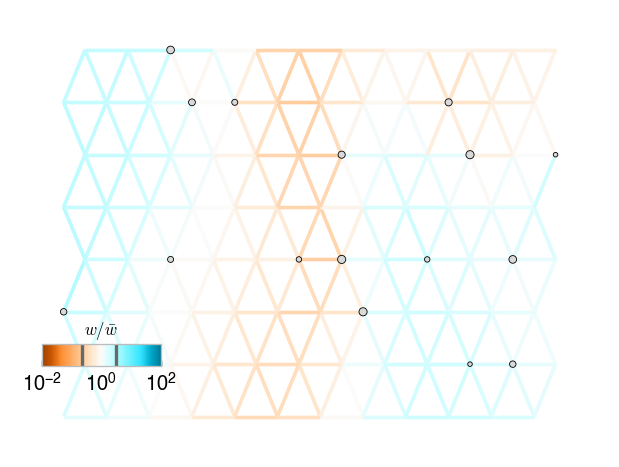

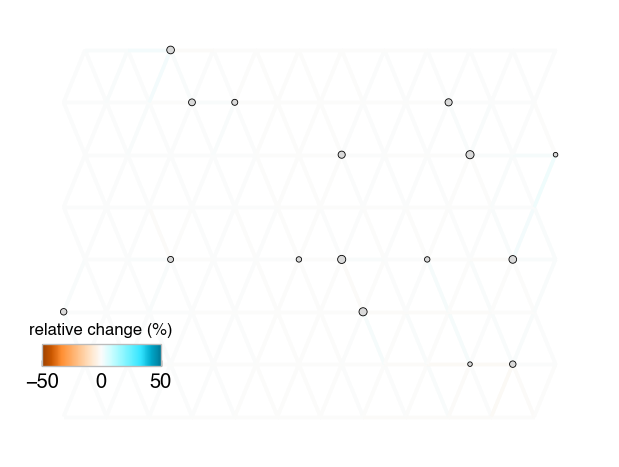

In [823]:
# results = pd.DataFrame(index=range(16), columns=['ss','n_e','lamb_cv','lamb_q_cv','baselinew','baselines2','outliers','baselinell',
#                                                 'mle_point_ll','mle_point_id','mle_point_c','mle_point_loc','all_point_ll','all_point_c',
#                                                 'mle_joint_ll','mle_joint_id','mle_joint_c','mle_joint_loc','all_joint_ll','all_joint_c'])
for rep in range(16):
    ## removing the source from the grid
    coord = sims[rep][3][list(range(np.sum(sims[rep][1][:51])//2))+list(range(np.sum(sims[rep][1][:52])//2,np.sum(sims[rep][1])//2)),:]
    gen_test = sims[rep][0][list(range(np.sum(sims[rep][1][:51])//2))+list(range(np.sum(sims[rep][1][:52])//2,np.sum(sims[rep][1])//2)),:]
    gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==0)[0],1)
    gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==2*gen_test.shape[0])[0],1)

    results.loc[rep,'ss'] = sims[rep][1]
    results.loc[rep,'n_e'] = sims[rep][2]

    ## creating the object
    sp_graph = FEEMSmix_SpatialGraph(gen_test, coord, grid_def, edge_def)
    
    ## CV scheme (10-fold and LOO gives similar results for these sims)
    lamb_grid = np.geomspace(1e-2,1e2,12,endpoint=True)[::-1]; lamb_q_grid = np.geomspace(1e-2,1e2,5,endpoint=True)[::-1]
    cv_err = run_cv_joint(sp_graph, lamb_grid, lamb_q_grid, n_folds=10, factr=1e10)
    mean_cv_err = np.mean(cv_err, axis=0)
    lamb_q_cv = lamb_q_grid[np.where(mean_cv_err == np.min(mean_cv_err))[0][0]]
    lamb_cv = lamb_grid[np.where(mean_cv_err == np.min(mean_cv_err))[1][0]]

    results.loc[rep,'lamb_cv'] = lamb_cv
    results.loc[rep,'lamb_q_cv'] = lamb_q_cv

    ## baseline fit
    sp_graph.fit(lamb=lamb_cv,optimize_q='n-dim',lamb_q=lamb_q_cv, verbose=False); 
    obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)

    fig = plt.figure(dpi=120)
    ax = fig.add_subplot(1, 1, 1)
    v = Viz(ax, sp_graph, projection=None, edge_width=2, abs_max=2, 
            edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
    v.draw_edges(use_weights=True); v.draw_edge_colorbar(); v.draw_obs_nodes()

    # store the baseline weights for plotting later
    results.loc[rep,'baselinew'] = sp_graph.w
    results.loc[rep,'baselines2'] = sp_graph.s2
    results.loc[rep,'baselinell'] = -obj.eems_neg_log_lik()

    top = obj.extract_outliers()

    ## store the # of unique occurrences 
    results.loc[rep,'outliers'] = [(top['dest.'].value_counts().idxmax(), top['dest.'].value_counts().iloc[0])]

    ## run the point estimation framework 
    df = obj.calc_contour(destid=44, search_area='all', exclude_boundary=True)

    results.loc[rep,'mle_point_id'] = df['(source, dest.)'].iloc[np.argmax(df['log-lik'])][0]
    results.loc[rep,'mle_point_c'] = df['admix. prop.'].iloc[np.argmax(df['log-lik'])]
    results.loc[rep,'mle_point_ll'] = df['log-lik'].iloc[np.argmax(df['log-lik'])]
    results.loc[rep,'mle_point_loc'] = str(sp_graph.nodes[df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0]]['pos'])
        
    ## storing all the point results 
    results.loc[rep,'all_point_c'] = df['admix. prop.'].to_string(index=False)
    results.loc[rep,'all_point_ll'] = df['log-lik'].to_string(index=False)
    
    ## running the joint estimation framework
    joint_df = pd.DataFrame(columns=['(source, dest.)', 'admix. prop.', 'log-lik'])
    for d in range(96):
        if d==44 #list(np.arange(0,12)) + list(np.arange(0,9)*12) + list(np.arange(1,9)*12-1) + list(np.arange(84,96)) + [44]:
            continue 
            
        sd = (d, 44)
        sp_graph.fit(lamb=lamb_cv,optimize_q='n-dim',lamb_q=lamb_q_cv,option='default',verbose=False)
        obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)
        try:
            sp_graph.fit(lamb=lamb_cv,long_range_edges=[sd],optimize_q='n-dim',lamb_q=lamb_q_cv,option='onlyc',verbose=False)
            obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)
        except:
            try:
                sp_graph.fit(lamb=10*lamb_cv,long_range_edges=[sd],optimize_q='n-dim',lamb_q=10*lamb_q_cv,option='onlyc')
                obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)
            except:
                continue
            
        joint_df.loc[len(joint_df)] = [sd, sp_graph.c[0], -obj.eems_neg_log_lik(sp_graph.c, {'edge':sp_graph.edge,'mode':'compute'})]

    ## what is the MLE deme (in the joint estimation framework)? 
    results.loc[rep,'mle_joint_id'] = joint_df['(source, dest.)'].iloc[np.argmax(joint_df['log-lik'])][0]
    results.loc[rep,'mle_joint_c'] = joint_df['admix. prop.'].iloc[np.argmax(joint_df['log-lik'])]
    results.loc[rep,'mle_joint_ll'] = joint_df['log-lik'].iloc[np.argmax(joint_df['log-lik'])]
    results.loc[rep,'mle_joint_loc'] = str(sp_graph.nodes[joint_df['(source, dest.)'].iloc[np.argmax(joint_df['log-lik'])][0]]['pos'])
    
    ## storing the joint results 
    results.loc[rep,'all_joint_c'] = joint_df['admix. prop.'].to_string(index=False)
    results.loc[rep,'all_joint_ll'] = joint_df['log-lik'].to_string(index=False)

    ## refit the graph in the joint framework & plot the results
    sp_graph.fit(lamb=lamb_cv,optimize_q='n-dim',lamb_q=lamb_q_cv,option='default',verbose=False); 
    try:
        sp_graph.fit(lamb=lamb_cv,long_range_edges=[(results['mle_joint_id'],44)],optimize_q='n-dim',lamb_q=lamb_q_cv,option='onlyc',verbose=False)
        obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False);
    except:
        sp_graph.fit(lamb=lamb_cv,optimize_q='n-dim',lamb_q=lamb_q_cv,option='default',verbose=False); 
        sp_graph.fit(lamb=10*lamb_cv,long_range_edges=[(results['mle_joint_id'],44)],optimize_q='n-dim',lamb_q=10*lamb_q_cv,option='onlyc',verbose=False)
        obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)

    fig = plt.figure(dpi=120)
    ax = fig.add_subplot(1, 1, 1)
    v = Viz(ax, sp_graph, projection=None, edge_width=2, oldweights=results.loc[rep,'baselinew'], halfrange=50,
            edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
    v.draw_edges(use_weights=True, use_foldchange=True); v.draw_edge_change_colorbar(); v.draw_obs_nodes()

    ## reset the baseline before doing just the residual fit
    sp_graph.fit(lamb=lamb_cv,optimize_q='n-dim',lamb_q=lamb_q_cv,option='default',verbose=True)
    obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)

    print(results[['lamb_cv','lamb_q_cv','baselinell','mle_point_ll','mle_joint_ll','mle_point_id','mle_joint_id','mle_point_c','mle_joint_c']])      

In [55]:
MLEloc = []; MLEdiff = []; MLEdf = pd.DataFrame(0, index=range(1,96), columns=['(source, dest.)','admix. prop.','log-lik','scaled log-lik']); MLEc = []; MLEidx = [] 
cnt = 0
# sampnodes = [2,4,10,14,15,20,25,28,30,37,46,55,57,61,63,66,80,81,86,89]
for i in range(16):
    sampnodes = np.sort(np.unique(np.random.choice(97,12,replace=False).tolist()+[51,44])).tolist()
    ss = [2*np.random.randint(1,11) if i in sampnodes else 0 for i in range(96)]

    graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=8, n_columns=12, corridor_w=1e-2, barrier_w=1e-3, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=4, barrier_endpt=8, n_samples_per_node=10, option=2, ss=ss)
    gen_test_80 = simulate_genotypes_w_admixture(graph_def, target_n_snps=1000, n_print=950, long_range_nodes=[(51,44)], admixture_props=[0.5], n_e=10**(1+np.random.random(96)*2), time_of_adm=[1e-8])
    coord = coord_def[list(range(np.sum(ss[:51])//2))+list(range(np.sum(ss[:52])//2,np.sum(ss)//2)),:]
    gen_test = gen_test_80[list(range(np.sum(ss[:51])//2))+list(range(np.sum(ss[:52])//2,np.sum(ss)//2)),:]
    gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==0)[0],1)
    gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==2*gen_test.shape[0])[0],1)

    # coord = coord_def[list(range(140))+list(range(150,200)),:]
    # gen_test = gen_test_80[i][list(range(140))+list(range(150,200)),:]
    # gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==0)[0],1)
    # gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==2*gen_test.shape[0])[0],1)

    sp_graph = FEEMSmix_SpatialGraph(gen_test, coord, grid_def, edge_def)
    
    lamb_grid = np.geomspace(1e-2,1e2,12,endpoint=True)[::-1]
    cv_err = run_cv(sp_graph, lamb_grid, n_folds=None, factr=1e10)
    mean_cv_err = np.mean(cv_err, axis=0)
    lamb_cv = lamb_grid[np.argmin(mean_cv_err)]
    
    sp_graph.fit(lamb=lamb_cv,optimize_q='n-dim',lamb_q=1., verbose=False); 
    obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)

    # avgw += np.log10(sp_graph.w) - np.mean(np.log10(sp_graph.w))

    top = obj.extract_outliers(0.2,verbose=False)
    # df = obj.calc_contour(destid=20,search_area='all',exclude_boundary=False)
    if len(top)==0:
        cnt+=1
    else:
        df = obj.calc_contour(destid=int(top['dest.'][0]), search_area='all', exclude_boundary=False)
        # df = obj.calc_contour(destid=20, search_area='all', exclude_boundary=False)

    # MLEloc.append(df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])])
    MLEloc.append(sp_graph.nodes[df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0]]['pos'])
    MLEidx.append(df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0])
    MLEc.append(df['admix. prop.'].iloc[np.argmax(df['scaled log-lik'])])
    # MLEc.append(df.loc[df['(source, dest.)']==(63,20)]['admix. prop.'][63])
    MLEdiff.append(df['scaled log-lik'].iloc[np.where(df['(source, dest.)']==(51,44))[0]].values[0])
    # if np.where(obj.perm_idx==df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0])[0]<sp_graph.n_observed_nodes:
    #     print(obj.neg_log_lik_c(df['admix. prop.'].iloc[np.argmax(df['scaled log-lik'])],{'lre':[(obj.perm_idx[df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0]],df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][1])],'mode':'sampled'})-obj.neg_log_lik_c(0,{'lre':[(obj.perm_idx[df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0]],df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][1])],'mode':'sampled'}))
    # else:
    #     print(obj.neg_log_lik_c(df['admix. prop.'].iloc[np.argmax(df['scaled log-lik'])],{'lre':[(obj.perm_idx[df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0]],df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][1])],'mode':'unsampled'})-obj.neg_log_lik_c(0,{'lre':[(obj.perm_idx[df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0]],df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][1])],'mode':'unsampled'}))

    MLEdf['(source, dest.)'] = df['(source, dest.)']
    MLEdf['admix. prop.'] += df['admix. prop.']
    MLEdf['scaled log-lik'] += df['scaled log-lik']
    MLEdf['log-lik'] += df['log-lik']
    # if df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])]==(63,20):
    #     cnt += 1 

MLEdf['admix. prop.'] /= 16
MLEdf['scaled log-lik'] /= 16
MLEdf['log-lik'] /= 16
MLEdf['scaled log-lik'] -= np.max(MLEdf['scaled log-lik'])
print('True source is MLE: {:d} times'.format(cnt))

Simulating ~SNP 0
Simulating ~SNP 950
Using a FDR of 0.2:

5 outlier deme pairs found
 source  dest.      source (lat., long.) dest. (lat., long.)     pval
     86     44 (0.8660254037844386, 3.5)          (0.0, 6.0) 0.000945
     36     44                (0.0, 6.0)          (0.0, 3.0) 0.001084
     75     44               (0.0, 11.0)          (0.0, 6.0) 0.001913
     73     44               (0.0, 10.0)          (0.0, 6.0) 0.003233
     87     44 (0.8660254037844386, 4.5)          (0.0, 6.0) 0.006240

Putative destination demes (and # of times the deme appears as an outlier) experiencing admixture:
44    5
Name: dest., dtype: int64
Optimizing likelihood over 95 demes in the graph...
0%...30%...60%...90%...Simulating ~SNP 0
Simulating ~SNP 950
Using a FDR of 0.2:

1 outlier deme pairs found
 source  dest.      source (lat., long.) dest. (lat., long.)     pval
     20     56 (0.8660254037844386, 1.5)          (0.0, 5.0) 0.000009

Putative destination demes (and # of times the deme appear

In [105]:
# print(np.unique(MLEc))
# df['admix. prop.'].iloc[np.argmax(df['scaled log-lik'])]
# obj.neg_log_lik_c(df['admix. prop.'].iloc[np.argmax(df['scaled log-lik'])],{'lre':[(df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0],df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][1])],'mode':'unsampled'})

0.24706666666666666
0.2596666666666666
0.2531333333333333
0.25453333333333333
0.2562
0.2626
0.25606666666666666
0.24719999999999998
0.24866666666666667
0.25579999999999997
0.258
0.2644
0.24780000000000002
0.2534
0.24906666666666666
0.2544666666666667
0.2512666666666667
0.2637333333333334
0.2462
0.2472666666666667
0.2607333333333334
0.2633333333333333
0.264
0.2563333333333333
0.251
0.25673333333333337
0.2613333333333333
0.26713333333333333
0.2668666666666667
0.2618666666666667
0.25953333333333334
0.26520000000000005
0.27233333333333337
0.2708
0.27213333333333334
0.2688666666666667


In [419]:
# MLEloc60 = np.zeros(10); MLEc60 = np.zeros(10); truell60 = np.zeros(10); truec60 = np.zeros(10)
MLEloc = []; MLEdiff = []; MLEdf = pd.DataFrame(0, index=range(1,80), columns=['(source, dest.)','admix. prop.','log-lik','scaled log-lik']); MLEc = []; MLEidx = []; avgw = np.zeros(len(edge_def)) #MLEct = []; truect = []
cnt = 0
for i in range(16):
    # coord = coord_def[list(range(220))+list(range(230,400)),:] #-> sparse sampling with only 10 nodes
    # coord = coord[list(range(19))+list(range(20,36)),:]
    # coord = coord_def[list(range(320))+list(range(330,490)),:]
    # gen_test = gen_test_80[i][list(range(320))+list(range(330,490)),:]
    # gen_test = gen_test[list(range(19))+list(range(20,36)),:]
    # gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==0)[0],1)
    # gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==2*gen_test.shape[0])[0],1)

    sp_graph = FEEMSmix_SpatialGraph(gen_test_80[i], coord_def, grid_def, edge_def)
    sp_graph.fit(lamb=10.,optimize_q='n-dim',lamb_q=30., verbose=False); 
    obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False)

    avgw += np.log10(sp_graph.w) - np.mean(np.log10(sp_graph.w))

    top = obj.extract_outliers(0.001,verbose=False)
    # df = obj.calc_contour(destid=20,search_area='all',exclude_boundary=False)
    if len(top)==0:
        cnt+=1
    else:
        df = obj.calc_contour(destid=int(top['dest.'][0]), search_area='all')

    # MLEloc.append(df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])])
    MLEloc.append(sp_graph.nodes[df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0]]['pos'])
    MLEidx.append(df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0])
    MLEc.append(df['admix. prop.'].iloc[np.argmax(df['scaled log-lik'])])
    # MLEdiff.append(df['scaled log-lik'].iloc[np.where(df['(source, dest.)']==(63,20))[0]].values[0])

    # if df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0]%2:
    #     MLEct.append(sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.5,0.001],args={'lre':[(np.where(obj.perm_idx==df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0])[0][0],8)],'mode':'sampled'},method='L-BFGS-B',bounds=[(0,1),(0,0.005)]).x)
    # else:
    #     MLEct.append(sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.5,0.001],args={'lre':[(np.where(obj.perm_idx==df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0])[0][0],8)],'mode':'unsampled'},method='L-BFGS-B',bounds=[(0,1),(0,0.005)]).x)
    # truect.append(sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.5,0.001],args={'lre':[(63,10)],'mode':'unsampled'},method='L-BFGS-B',bounds=[(0,1),(0,0.005)]).x)
    
    MLEdf['(source, dest.)'] = df['(source, dest.)']
    MLEdf['admix. prop.'] += df['admix. prop.']
    MLEdf['scaled log-lik'] += df['scaled log-lik']
    MLEdf['log-lik'] += df['log-lik']
    # if df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])]==(63,20):
    #     cnt += 1 

MLEdf['admix. prop.'] /= 16
MLEdf['scaled log-lik'] /= 16
MLEdf['log-lik'] /= 16
MLEdf['scaled log-lik'] -= np.max(MLEdf['scaled log-lik'])
print('True source is MLE: {:d} times'.format(cnt))
avgw /= 16

Using a significance threshold of 0.001:

No outliers found.
Consider raising the significance threshold slightly.


Using a significance threshold of 0.001:

1 outlier deme pairs found
 source  dest.      source (lat., long.)       dest. (lat., long.)     pval
     51     14 (3.4641016151377544, 3.0) (0.8660254037844386, 2.5) 0.000788

Putative destination demes (and # of times the deme appears as an outlier) experiencing admixture:
14    1
Name: dest., dtype: int64
Optimizing likelihood over 59 demes in the graph...
0%...30%...Using a significance threshold of 0.001:

No outliers found.
Consider raising the significance threshold slightly.
Using a significance threshold of 0.001:

No outliers found.
Consider raising the significance threshold slightly.
Using a significance threshold of 0.001:

No outliers found.
Consider raising the significance threshold slightly.
Using a significance threshold of 0.001:

No outliers found.
Consider raising the significance threshold slightly.
Using a significance threshold of 0.001:

No outliers found.
Consider raising the significance threshold slightly.
Using a

In [294]:
# plt.plot([1e-4,1e-3,1e-2,0.05,0.1,0.25,0.5,1],[0.13019761197484192,0.12902149935293244,0.1525418528222208,0.2596411144597768,0.3533682636707458,0.6133418878657412,1.0252415513544038,1.7361586277801393],'ko'); plt.axline((1,1),slope=1,color='grey',ls='--')
# plt.errorbar([1e-4,1e-3,1e-2,0.05,0.1,0.25,0.5,1],[0.13019761197484192,0.12902149935293244,0.1525418528222208,0.2596411144597768,0.3533682636707458,0.6133418878657412,1.0252415513544038,1.7361586277801393],yerr=2*np.array([0.022712280888398006,0.02512421169863045,0.027121704897425686,0.04519398722241161,0.04100375527102841,0.0613764922651444,0.09075075842841175,0.14649618822602764]),color='k'); plt.xlabel('msprime simulated weights'); plt.ylabel('FEEMS estimated weights'); plt.semilogx()
# sp.optimize.minimize(obj.neg_log_lik_c_t,x0=[0.5,0.001],args={'lre':[df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])]],'mode':'unsampled'},method='Nelder-Mead',bounds=[(0,1),(0,0.005)])
# sp.optimize.minimize(obj.neg_log_lik_c, 0.5, bounds=[(0.0,1)], args={'lre':[(46,8)],'mode':'unsampled'})
# np.where(MLEdf['scaled log-lik'].isna())
# plt.hist2d(np.array(MLEloc)[:,0],np.array(MLEloc)[:,1],cmap='Greens'); plt.ylim((0,6.5)); plt.xlim((0,10)); plt.colorbar()
# (np.where(obj.perm_idx==df['(source, dest.)'].iloc[np.argmax(df['scaled log-lik'])][0])[0][0],8)

# df = obj.calc_contour(destid=44,search_area='all',exclude_boundary=False)

Optimizing likelihood over 95 demes in the graph...(20, 10)
(21, 10)
(28, 10)
25%...50%...75%...done!


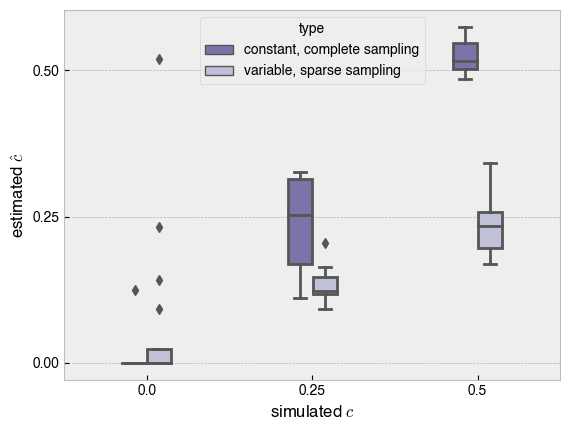

In [90]:
# plt.plot(range(1,11),[np.sum(np.array(MLEdiff)>-l)/16 for l in range(1,11)], 'k-o'); plt.xticks([1,2,5,10]); plt.yticks(np.linspace(0,1,6)); plt.ylim(-0.05,1.05); plt.xlabel('log-lik units'); plt.ylabel('coverage (% of simulations)'); plt.title('True source is MLE: {:d} times'.format(np.sum(np.array(MLEdiff)==0)))
# plt.plot([1,2,5,10],[0.125,0.3125,0.75,1],'-o',color='#bcbddc',label='variable, sparse sampling'); plt.plot([1,2,5,10],[1,1,1,1],'-o',color='#756bb1', label='constant, complete sampling'); plt.xticks([1,2,5,10]); plt.yticks(np.linspace(0,1,6)); plt.ylim(-0.05,1.05); plt.xlabel('log-lik units'); plt.ylabel('coverage (% of simulations)'); plt.legend(loc='lower right')
# plt.boxplot()
# cdf = pd.DataFrame(index=range(96),columns=['type','est','sim'])
# cdf['type']=['constant, complete sampling']*16+['variable, sparse sampling']*16+['constant, complete sampling']*16+['variable, sparse sampling']*16+['constant, complete sampling']*16+['variable, sparse sampling']*16
# cdf['est']=[0.5743480738370997, 0.4902729070210063, 0.49282287090315613, 0.5455559419914989, 0.5039563000329709, 0.4850978437546994, 0.5598384908795011, 0.5495644389505717, 0.5248721360529178, 0.5106234969716548, 0.5496342412531557, 0.4952464193005423, 0.5177684531031223, 0.5137405372490839, 0.5224291688940094, 0.5136871582149971, 0.19371606569014557, 0.23486431848486392, 0.18861058809176978, 0.2616936165264482, 0.16907182962649267, 0.19736190804066767, 0.3002343306352451, 0.19920708162342096, 0.24857103473472086, 0.25544873790944234, 0.23479159335343797, 0.2065143934684539, 0.3422038303878835, 0.32438441137971263, 0.23234157084888354, 0.1851120280203002]+[0]*15+[0.124]+[0]*12+[0.09142194, 0.14122939, 0.23176735, 0.52] + [0.23615423470374683, 0.23179938547446116, 0.2910049338095276, 0.22772387631990645, 0.21058039229455994, 0.2592193237563318, 0.16549799034402231, 0.20008059020620725, 0.28013599814492435, 0.17345993464531526, 0.21005166710813566, 0.28364075919416515, 0.29204199343861753, 0.2408856355420014, 0.16258867411318714, 0.26260108165405196] + [0.1642786231227975, 0.11396230427825454, 0.14294382680849255, 0.09245872759906623, 0.20538044780935952, 0.12085596575613326, 0.11905116632875408, 0.10682290425874984, 0.12523596353067024, 0.10531319002521386, 0.14870438471599967, 0.11954875410639637, 0.1374217981544359, 0.14707180019728186, 0.14903737248958693, 0.1198798253697746]
# cdf['sim'] = [0.5]*32+[0]*32+[0.25]*32
# sns.boxplot(data=cdf,x='type',y='est',palette=['#756bb1','#bcbddc'],width=0.3); plt.ylim(-0.05,1.05); plt.axhline(0.5,color='red'); plt.ylabel(r'$\hat c$')
# sns.boxplot(data=cdf,x='sim',y='est',hue='type',palette=['#756bb1','#bcbddc'],width=0.3); plt.ylabel(r'estimated $\hat c$');  plt.xlabel(r'simulated $c$'); plt.yticks([0,0.25,0.5]); 

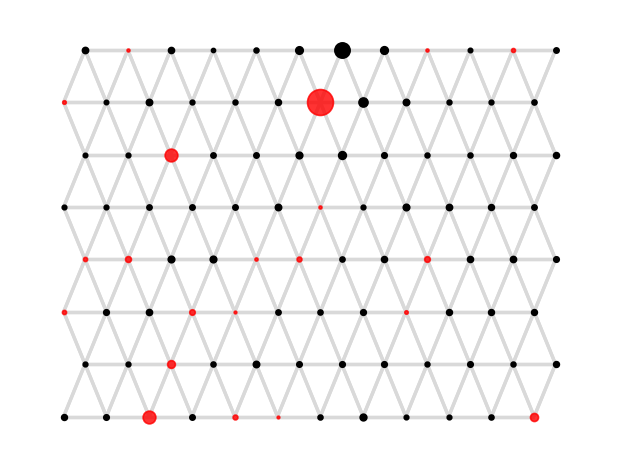

In [46]:
# np.array(MLEloc).std(axis=0)
# np.array(MLEloc).std(axis=0), np.array(MLEloc).mean(axis=0)
# sp_graph.fit(lamb=3., optimize_q='n-dim', lamb_q=0.)
fig = plt.figure(dpi=120)
ax = fig.add_subplot(1, 1, 1)
v = Viz(ax, sp_graph, obj, projection=None, edge_width=2,
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
v.draw_edges(use_weights=False); #v.draw_edge_colorbar()
q = []
for i in range(96):
    ip = np.where(obj.perm_idx==i)[0][0]
    if ip<sp_graph.n_observed_nodes:
        v.ax.plot(v.grid[i,0], v.grid[i,1], 'ro', alpha=0.8, markersize=20/sp_graph.q[ip])
        # v.ax.plot(v.grid[i,0], v.grid[i,1], 'ro', alpha=0.8, markersize=np.linspace(1,8,80,endpoint=True)[i])#np.concatenate((np.repeat(1,30), np.repeat(10,25), np.repeat(100,25)))[i]/5)
    else:
        R1 = np.array(-2*obj.Lpinv[:sp_graph.n_observed_nodes,ip].T + np.diag(obj.Linv) + obj.Lpinv[ip,ip])
        proxs = np.argsort([nx.shortest_path_length(sp_graph,source=ip,target=d) for d in set(obj.perm_idx[:sp_graph.n_observed_nodes])-set([ip])])[:10]
        # qprox = np.dot(1/sp_graph.q[proxs], (1/R1[0,proxs].T)/np.sum(1/R1[0,proxs]))
        qprox = np.dot(1/sp_graph.q[proxs], (R1[0,proxs]*np.exp(-2*R1[0,proxs]))/np.sum(R1[0,proxs]*np.exp(-2*R1[0,proxs])))
        q.append(qprox)
        v.ax.plot(v.grid[i,0], v.grid[i,1], 'ko', markersize=20*qprox)
        # v.ax.plot(v.grid[i,0], v.grid[i,1], 'ko', alpha=0.8, markersize=np.concatenate((np.repeat(1,20), np.repeat(3,20), np.repeat(10,20), np.repeat(30,20)))[i])

In [546]:
# print(np.exp(newres[0][:sp_graph.size()]), np.exp(newres[0][sp_graph.size():-1]), newres[0][-1])

422.50347248268645

In [617]:
# plt.plot(np.concatenate((np.repeat(1,30), np.repeat(10,25), np.repeat(100,25))),1/sp_graph.q,'ro'); plt.xlabel(r'simulated $N_e$'); plt.ylabel(r'$1/\hat q$'); plt.semilogx()
# plt.plot(np.arange(1,81),1/sp_graph.q,'ro'); plt.xlabel(r'simulated $N_e$'); plt.ylabel(r'$1/\hat q$'); 
# np.mean(sp_graph.q)

# sp.stats.linregress(np.concatenate((np.repeat(1,30), np.repeat(10,25), np.repeat(100,25))),1/sp_graph.q,)
# print(sp.stats.linregress(np.arange(1,81),1/sp_graph.q))
# sp_graph.fit(lamb=2.,optimize_q='n-dim',lamb_q=2.)
# obj = FEEMSmix_Objective(sp_graph); obj.extract_outliers(0.1)
# df = obj.calc_contour(destid=44,exclude_boundary=True); df.iloc[np.argmax(df['log-lik'])]

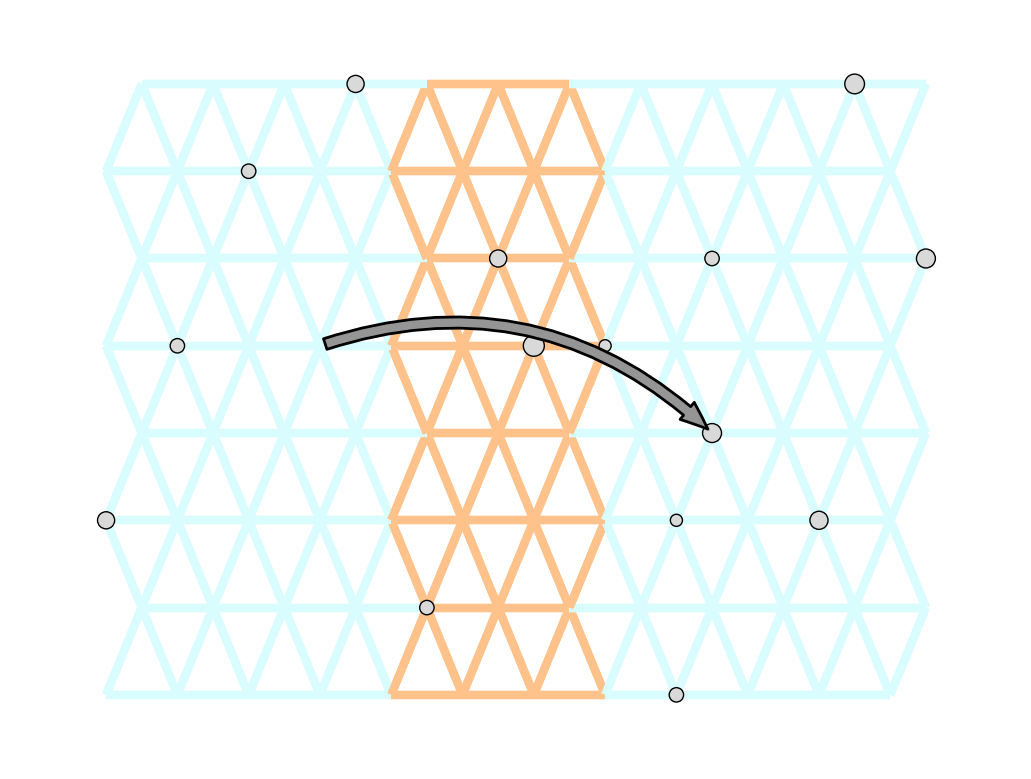

In [1263]:
# def get_true_weights(barrier_w=1e-3, corridor_w=1e-2, n_rows=8, n_columns=12, barrier_startpt=4, barrier_endpt=7):
#     graph, coord, grid, edges = setup_graph_long_range(n_rows=n_rows,
#                                             n_columns=n_columns,
#                                             barrier_startpt=barrier_startpt,
#                                             barrier_endpt=barrier_endpt,
#                                             barrier_w=barrier_w,
#                                             corridor_w=corridor_w)
#     W = nx.adjacency_matrix(graph, weight="w")
#     idx = nx.adjacency_matrix(graph).nonzero()
#     idx = list(np.column_stack(idx))
#     true_weights = np.array([])
#     for i in range(len(idx)):
#         true_weights = np.append(true_weights, W[idx[i][0],idx[i][1]])
    
#     return(true_weights)

true_weights = get_true_weights(); true_weights[np.where(true_weights==0.5)[0]] = 0.01
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1)
v = Viz(ax, sp_graph, projection=None)
v.norm_log_weights = np.log10(true_weights) - np.mean(np.log10(true_weights))
v.obs_node_size = 19; v.edge_width=3; v.abs_max = 2; v.obs_node_linewidth = 0.5; v.cbar_ticklabelsize = 12
# v.cbar_width = "20%"; v.cbar_height = "5%"; v.cbar_loc = "lower left"; v.cbar_bbox_to_anchor = (0.05, 0.2, 1, 1)
# v.draw_edge_colorbar()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False)
v.draw_arrow([(51,44)],0.5,tw=4,hw=8,hl=10);

## Jointly estimating $w, q$ and $c$ using $\texttt{scipy.optimize}$ and a function with computed gradients 

Issue currently is that this scheme just draws all weights to the average value (typically, $\bar w \approx 1.1$), but estimates $c$ correctly. What if I use a different function with precomputed weights?

In [101]:
## graph setup
# sampnodes = [2,14,18,25,31,44,46,51,57,66,74,77]
# ss = [2*np.random.randint(1,11) if i in sampnodes else 0 for i in range(96)]
# graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=8, n_columns=12, corridor_w=1e-2, barrier_w=1e-3, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=4, barrier_endpt=7, n_samples_per_node=10, option=2, ss=ss)
# gen_test_80 = simulate_genotypes_w_admixture(graph_def, target_n_snps=1000, n_print=500, long_range_nodes=[(51,44)], admixture_props=[0.3], n_e=100, time_of_adm=[1e-7])
# coord = coord_def[list(range(np.sum(ss[:51])//2))+list(range(np.sum(ss[:52])//2,np.sum(ss)//2)),:]
# gen_test = gen_test_80[list(range(np.sum(ss[:51])//2))+list(range(np.sum(ss[:52])//2,np.sum(ss)//2)),:]
# gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==0)[0],1)
# gen_test = np.delete(gen_test,np.where(gen_test.sum(axis=0)==2*gen_test.shape[0])[0],1)
# sp_graph = FEEMSmix_SpatialGraph(gen_test, coord, grid_def, edge_def)


 fold:  0
iteration lambda_q=5/5 lambda=12/12
 fold:  1
iteration lambda_q=5/5 lambda=12/12
 fold:  2
iteration lambda_q=5/5 lambda=12/12
 fold:  3
iteration lambda_q=5/5 lambda=12/12
 fold:  4
iteration lambda_q=5/5 lambda=12/12
 fold:  5
iteration lambda_q=5/5 lambda=12/12
 fold:  6
iteration lambda_q=5/5 lambda=12/12
 fold:  7
iteration lambda_q=5/5 lambda=12/12
 fold:  8
iteration lambda_q=5/5 lambda=12/12
 fold:  9
iteration lambda_q=5/5 lambda=12/12
 fold:  10
iteration lambda_q=5/5 lambda=12/12
 fold:  11
iteration lambda_q=5/5 lambda=12/12
 fold:  12
iteration lambda_q=5/5 lambda=12/12
 fold:  13
iteration lambda_q=5/5 lambda=12/12
 fold:  14
iteration lambda_q=5/5 lambda=12/12
 fold:  15
iteration lambda_q=5/5 lambda=12/12
 fold:  16
iteration lambda_q=5/5 lambda=12/12

Text(0, 0.5, 'LOO-CV error')

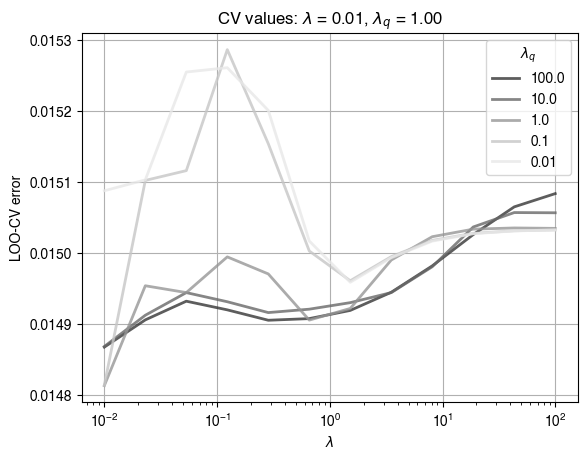

In [102]:
# lamb_grid = np.geomspace(1e-2,1e2,12,endpoint=True)[::-1]
# lamb_q_grid = np.geomspace(1e-2,1e2,5,endpoint=True)[::-1]
cvq_err = run_cv_joint(sp_graph, lamb_grid, lamb_q_grid, n_folds=None, factr=1e7)
# plt.plot(lamb_grid,np.mean(cvq_err,axis=(0,1)),'k-o',label=r'$\lambda_w$'); plt.xlabel('values'); plt.ylabel('LOO CV error'); 
# plt.plot(lamb_q_grid,np.mean(cvq_err,axis=(0,2)),'-o',color='grey',label=r'$\lambda_q$'); plt.semilogx(); plt.legend(); 

mean_cv_err = np.nanmean(cvq_err, axis=0)
plt.gca().set_prop_cycle(color=[plt.get_cmap('Greys_r').resampled(len(lamb_q_grid)+2)(i) for i in range(1,len(lamb_q_grid)+1)])
lineObj = plt.plot(lamb_grid, mean_cv_err.T, linewidth=2, alpha=0.8)
plt.title(r'CV values: $\lambda$ = {:.2f}, $\lambda_q$ = {:.2f}'.format(lamb_grid[np.where(mean_cv_err == np.min(mean_cv_err))[1][0]],lamb_q_grid[np.where(mean_cv_err == np.min(mean_cv_err))[0][0]]))
plt.legend(lineObj, lamb_q_grid, title=r'$\lambda_q$'); plt.grid(); plt.xlabel(r'$\lambda$'); plt.semilogx(); plt.ylabel('LOO-CV error')
# print(np.where(np.nanmin(np.nanmean(cvq_err,axis=0))==np.nanmean(cvq_err,axis=0))[1][0])
# np.geomspace(1e-2,1e2,6,endpoint=True)[::-1][3], lamb_grid[5]

In [103]:
sp_graph.fit(lamb=0.01,optimize_q=None,lamb_q=1.); obj = Objective(sp_graph); 
obj.inv(); obj.grad(reg=False); obj.Lpinv = np.linalg.pinv(sp_graph.L.todense())

# oldw = deepcopy(sp_graph.w); olds2 = deepcopy(sp_graph.s2)
# print(obj.eems_neg_log_lik(), sp_graph.c) # -> 813.9
# df = obj.calc_contour(destid=44,exclude_boundary=False)
# %time joint_contour = obj.calc_joint_contour(destid=44, sourceid=51, search_area='radius', opts=2, lamb=1.5, lamb_q=0.5)
# joint_contour
# np.max(joint_df['log-lik'].loc[:0])
# joint_contour, obj.calc_contour(44,sourceid=51,search_area='radius',opts=2)
# joint_contour, joint_df.loc[topidx-1], df.loc[topidx]
# df
# print(df)
# sp_graph.option='onlyc'

constant-w/variance fit, converged in 30 iterations, train_loss=-3390.4826801
lambda=0.010, alpha=0.6274, converged in 380 iterations, train_loss=-4605.525


Log-likelihood of initial fit: -580.6

Using a FDR of 0.25:

4 outlier deme pairs found

Putative destination demes:[30 36 44 66]
36    1
30    1
44    1
66    1
Name: dest., dtype: int64
Multiple putative outlier demes ([36, 30, 44, 66]) found, but only adding deme 36

Fitting long range edge to deme 36...
Optimizing likelihood over 60 demes in the graph...25%...50%...done!
Jointly optimizing likelihood over 5 demes in the graph...
0...1...2...joint estimation converged in 3 iterations!
lambda=0.010, alpha=0.2852, converged in 1 iterations, train_loss=598.154
0...1...2...joint estimation converged in 3 iterations!
lambda=0.010, alpha=0.2852, converged in 1 iterations, train_loss=598.248
0...1...2...joint estimation converged in 3 iterations!
lambda=0.010, alpha=0.2852, converged in 1 iterations, train_loss=598.445
0...1...2...3...joint estimation converged in 4 iterations!
lambda=0.010, alpha=0.2852, converged in 1 iterations, train_loss=598.963
0...1...2...3...joint estimation conver

TypeError: 'AxesSubplot' object is not subscriptable

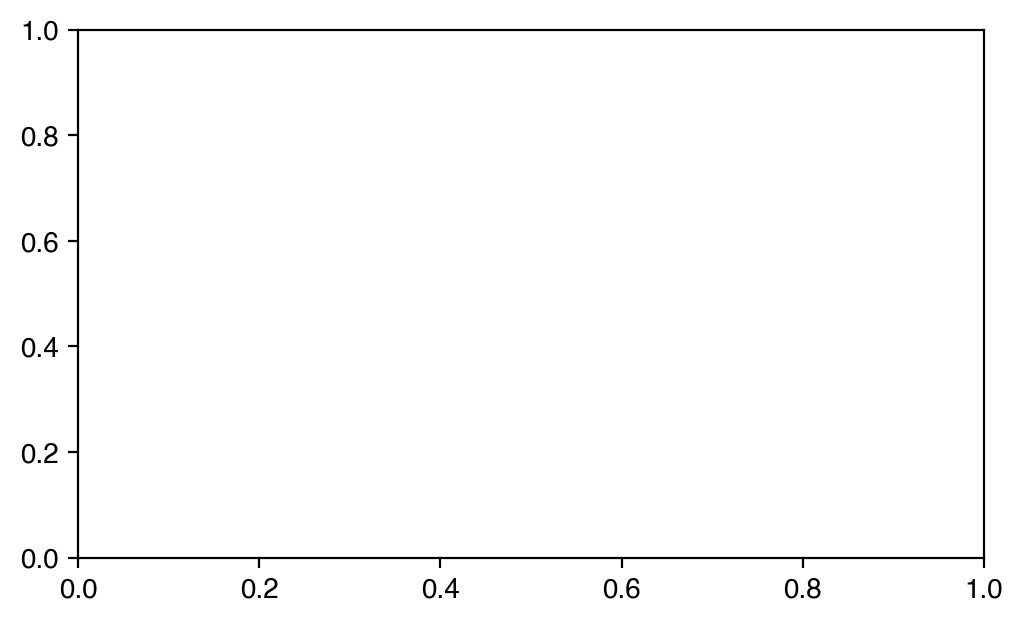

In [104]:
seq_results = sp_graph.sequential_fit(lamb=0.01, lamb_q=1., optimize_q=None, top=5)
fig, axs = plt.subplots(1, len(seq_results), dpi=200, figsize=(5,3), sharey=True, constrained_layout=True)
# plt.ylabel('genetic distance'); plt.xlabel('fitted distance')
X = sm.add_constant(seq_results[0]['fit_dist'])
mod = sm.OLS(seq_results[0]['emp_dist'], X)
res = mod.fit()
muhat, betahat = res.params
axs[0].scatter(seq_results[0]['fit_dist'], seq_results[0]['emp_dist'], marker=".", alpha=0.8, zorder=0, color="k", s=20)
bh = benjamini_hochberg(seq_results[0]['emp_dist'], seq_results[0]['fit_dist'], fdr=seq_results[0]['fdr'])
axs[0].scatter(seq_results[0]['fit_dist'][bh], seq_results[0]['emp_dist'][bh], marker='x', color='r', s=20, alpha=0.8)
x_ = np.linspace(np.min(seq_results[0]['fit_dist']), np.max(seq_results[0]['fit_dist']), 20);
axs[0].plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=1.5);
axs[0].text(0.6, 0.2, "R²={:.3f}".format(res.rsquared), transform=axs[0].transAxes, size='large')
axs[0].set_title('Baseline')
fig.supxlabel('fitted distance'); fig.supylabel('genetic distance');
for i in range(1,len(seq_results)):
    X = sm.add_constant(seq_results[i]['fit_dist'])
    mod = sm.OLS(seq_results[0]['emp_dist'], X)
    res = mod.fit()
    muhat, betahat = res.params
    axs[i].scatter(seq_results[i]['fit_dist'], seq_results[0]['emp_dist'], marker=".", alpha=0.8, zorder=0, color="k", s=20)
    axs[i].scatter(seq_results[i]['fit_dist'][bh], seq_results[0]['emp_dist'][bh], marker='.', color='r', s=20, alpha=0.8)
    axs[i].scatter(seq_results[i-1]['fit_dist'][bh], seq_results[0]['emp_dist'][bh], marker='x', color='r', s=20, alpha=0.8)
    for il in range(np.sum(bh)):
        # axs[i].plot((seq_results[i]['fit_dist'][bh][il], seq_results[i-1]['fit_dist'][bh][il]), 
        #             (seq_results[0]['emp_dist'][bh][il], seq_results[0]['emp_dist'][bh][il]), color='r', linewidth=2)
        axs[i].annotate(
            '',  # No text
            xy=(seq_results[i-1]['fit_dist'][bh][il], seq_results[0]['emp_dist'][bh][il]),  # Arrow end (head)
            xytext=(seq_results[i]['fit_dist'][bh][il], seq_results[0]['emp_dist'][bh][il]),  # Arrow start (tail)
            arrowprops=dict(
                arrowstyle="<-",  # Arrow style
                color='r',  # Color of the arrow
                linewidth=1  # Width of the arrow line
            )
        )
    x_ = np.linspace(np.min(seq_results[i]['fit_dist']), np.max(seq_results[i]['fit_dist']), 20); 
    axs[i].plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=1.5); 
    axs[i].text(0.6, 0.2, "R²={:.3f}".format(res.rsquared), transform=axs[i].transAxes, size='large')
    axs[i].set_title('On fitting deme {:d}'.format(seq_results[i]['deme']))
# joint_df.iloc[np.argmax(joint_df['scaled log-lik'])]
# plt.hist(df['log-lik'] - joint_df['log-lik'],20)
# plt.figure(dpi=150)
# plt.plot(range(95), np.array(joint_df['log-lik']) - np.array(df['log-lik']), 'ko',); plt.ylabel("increase in log-lik with a 'joint' fit")
# plt.xticks(range(95),labels=[i for i in range(96) if i != 44],rotation=45, fontsize=4); 
# sp.stats.chi2.sf(2*(np.array(joint_df['log-lik']) - np.array(df['log-lik'])), 100)

# plt.figure(dpi=150); plt.axhline(2*840, color='red')
# plt.plot(range(95), 2*264-2*joint_df['log-lik'], 'o', color='#66c2a5', label='joint'); plt.plot(range(95), 2 - 2*df['log-lik'], 'o', alpha=0.8, color='#fc8d62', label='point'); 
# plt.xticks(range(95),labels=[i for i in range(96) if i != 44],rotation=45, fontsize=4); plt.legend(title='method'); plt.ylabel('log-lik')

In [1477]:
# obj.lamb = 5e-1; obj.alpha = 1/sp_graph.w0.mean(); obj.lamb_q = 1.; obj.alpha_q = 1/sp_graph.s2.mean()
# %timeit sp.optimize.minimize_scalar(obj.eems_neg_log_lik,args={'edge':[(51,44)],'mode':'compute'},bounds=[(0,1)])
# %timeit sp.optimize.minimize(obj.eems_neg_log_lik,0.1,bounds=[(0,1)],tol=1e-2,method='L-BFGS-B',args={'edge':[(51,1)],'mode':'compute'})
# newres = sp.optimize.fmin_l_bfgs_b(obj.joint_eems_neg_log_lik,x0=np.r_[np.log(obj.sp_graph.w),np.log(obj.sp_graph.s2),0.1],approx_grad=True, 
#                                          args=[{'edge':[(71,38)]}],factr=1e10,maxiter=1000,maxls=20,bounds=[(-np.inf,np.inf) for _ in range(len(sp_graph.w)+len(sp_graph.s2))]+[(0,1)])
# print(np.exp(newres[0][:sp_graph.size()]), np.exp(newres[0][sp_graph.size():-1]), newres[0][-1])
# %time res = coordinate_descent(obj, [(88,38)], factr=1e7)
# joint_df = pd.DataFrame(columns=['(source, dest.)', 'admix. prop.', 'log-lik', 'scaled log-lik'])
# for d in range(96):
#     if d==44:
#         continue 
#     sd = (d, 44)
#     sp_graph.fit(lamb=1.5,optimize_q='n-dim',lamb_q=.5,option='default')
#     try:
#         sp_graph.fit(lamb=1.5,long_range_edges=[sd],optimize_q='n-dim',option='onlyc')
#     except:
#         print(d)
#         sp_graph.fit(lamb=50.,optimize_q='n-dim',lamb_q=5.)
#         sp_graph.fit(lamb=50.,long_range_edges=[sd],lamb_q=5.,optimize_q='n-dim',option='onlyc')
#     joint_df.loc[len(joint_df)] = [sd, sp_graph.c[0], -obj.eems_neg_log_lik(sp_graph.c, {'edge':sp_graph.edge,'mode':'compute'}), 0]
# joint_df['scaled log-lik'] = joint_df['log-lik'] - np.max(joint_df['log-lik']) 

# %time sp_graph.fit(lamb=.5,long_range_edges=[(51,44)],optimize_q='n-dim',lamb_q=.5,option='onlyc'); print(sp_graph.c)

# obj.eems_neg_log_lik(sp_graph.c, {'edge':sp_graph.edge,'mode':'compute'})
# res
# print(res[1], sp_graph.c)
# np.corrcoef(sp_graph.w, np.exp(newres[0][:len(sp_graph.w)]))
# np.savetxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/sims/spacemix_freq.txt",sp_graph.frequencies*np.sqrt(sp_graph.mu*(1-sp_graph.mu))/2)
# np.savetxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/sims/spacemix_ss.txt",sp_graph.n_samples_per_obs_node_permuted)
# longlat = []
# for i in range(sp_graph.n_observed_nodes):
#     longlat.append(list(sp_graph.nodes[obj.perm_idx[i]]['pos']))
# np.savetxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/sims/spacemix_longlat.txt",np.array(longlat))

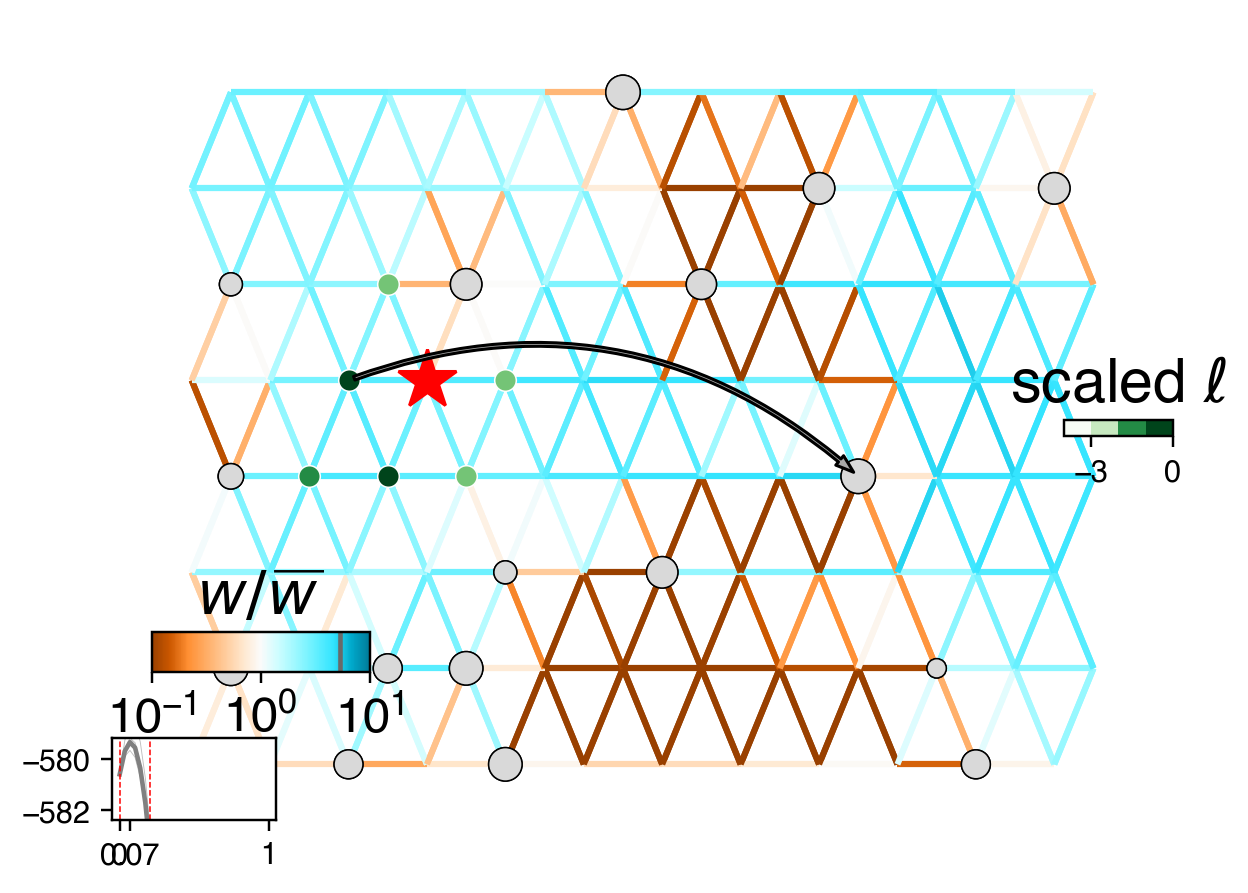

In [105]:
fig = plt.figure(dpi=220)
ax = fig.add_subplot(1, 1, 1)
v = Viz(ax, sp_graph, projection=None, edge_width=2, abs_max=1, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=40, sample_pt_color="black", cbar_font_size=20, cbar_ticklabelsize=16)
v.draw_edges(use_weights=True); v.draw_edge_colorbar(); v.draw_obs_nodes()
v.draw_ll_contour(df,levels=-3); v.draw_obs_nodes(use_ids=False); 
v.ax.plot(v.grid[51,0],v.grid[51,1],'r*',markersize=20,linewidth=50)

# fig = plt.figure(dpi=120)
# ax = fig.add_subplot(1, 1, 1)
# v = Viz(ax, sp_graph, projection=None, edge_width=2, oldweights=oldw, halfrange=100,
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, obs_node_size=7.5, sample_pt_color="black", cbar_font_size=10)
# v.draw_edges(use_weights=True, use_foldchange=True); v.draw_edge_change_colorbar(); v.draw_obs_nodes()

In [1673]:
# randedge = [tuple(np.random.choice(range(80),size=2,replace=False)) for _ in range(100)]
# randedge = list(set(randedge)-set(sp_graph.edges))
# randedge = [(x,58) for x in list(set(range(144))-set([58]))] 
# truew = np.append(np.zeros(len(randedge)),[0.6,0,0,0,0,0,0,0,0])
# for e in [(23,56),(22,56),(24,56),(23,57),(23,55),(24,55),(12,56),(13,56),(32,56)]:
#     randedge.append(e)
# for e in [(56,23),(56,22),(56,24),(57,23),(55,23),(55,24)]:
#     randedge.append(e)
# for e in [(8,27),(7,27),(9,27),(8,26),(8,28)]:
#     randedge.append(e)
# for e in [(23,92),(22,92),(91,23),(92,24),(101,36),(102,36),(35,101),(117,36),(35,118)]:
#     randedge.append(e)
# print(randedge)

isc2 = np.zeros(len(randedge)); llc2 = np.zeros(len(randedge))
# sp_graph = Joint_SpatialGraph(gen_test_80_adm, coord_def, grid_def, edge_def); 
for ie, e in enumerate(randedge):
    # llc = []
    # for c in np.linspace(0,1,25): 
    #     # llc.append(get_FEEMS_demes_ll_w_c(sp_graph, obj, sp_graph.w, sp_graph.q, [e], c, df=1500, sigstar=0.5)[1])
    #     try: 
    #         llc.append(-get_FEEMS_demes_nll_w_c(c, sp_graph, obj, [e], form='matrix'))
    #     except:
    #         llc.append(-1e8)
    # logc[ie] = np.linspace(0,1,12)[np.argmin(np.abs(llc-np.max(llc)+2))] # llc[0] - llc[-1]
    # if np.argmax(llc)!=0:
    #     isc[ie] = 1
    # isc2[ie] = np.linspace(0,1,25)[np.argmax(llc)]
    if e[0]<80:
        res = sp.optimize.minimize_scalar(get_FEEMS_demes_nll_w_c, args=(sp_graph, obj, [e]), bounds=(0,1), method='bounded')
        # res = sp.optimize.minimize(get_FEEMS_demes_nll_w_c, x0=0.5, method='Nelder-Mead', bounds=[(0,1)], args=(sp_graph, obj, [e]))
        isc2[ie] = res.x; llc2[ie] = res.fun
    else:
        res = sp.optimize.minimize_scalar(get_FEEMS_udemes_nll_w_c, args=(sp_graph, obj, [e]), bounds=(0,1), method='bounded')
        # res = sp.optimize.minimize(get_FEEMS_udemes_nll_w_c, x0=0.5, method='L-BFGS-B', bounds=[(0,1)], args=(sp_graph, obj, [e]))
        # sp_graph.fit(lamb=2.,optimize_q='n-dim',option='onlyc',long_range_edges=[e]); sp_graph.c
        isc2[ie] = res.x #sp_graph.c; 
        llc2[ie] = res.fun #obj.neg_log_lik_c(sp_graph.c)
    # isc2[ie] = sp.optimize.minimize(get_grad_FEEMS_demes_nll_w_c,x0=0.5,args=({'sp_graph':sp_graph,'obj':obj,'lrn':[e]}),jac=False,method='Nelder-Mead',bounds=[[0,1]]).fun
    # isc[ie] = sp.optimize.minimize(get_grad_FEEMS_demes_nll_w_c,x0=0.5,args=({'sp_graph':sp_graph,'obj':obj,'lrn':[e]}),jac=True,method='L-BFGS-B',bounds=[[0,1]]).x

### Effect of changing $Nm$ on $\hat c$ AND is there a scaling parameter $\sigma^\star$ that I need to worry about?
### (or is it just $\approx 1$?)

For $6\times6$ grid with $Nm=1$, it is around 1 (tested for $c \in \{0, 0.5\}$). It is slightly less than 1 $(0.988)$ for $Nm=0.01$, and the $c$ estimates are upward biased as seen above (expected). The bias is smaller but still negative for a larger grid of $8 \times 12$. 

In [924]:
# n_rows, n_columns = 6, 6
# estchalf = np.zeros((10,3)); estsighalf = np.zeros((10,3))
# for iNm, Nm in enumerate([(100,1e-3),(100,1e-2),(100,1e-1)]):
#     print(Nm[0], Nm[1])
#     graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=Nm[1], barrier_w=Nm[1], barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=5, barrier_endpt=10, n_samples_per_node=30)
#     foo = lambda c: simulate_genotypes_w_admixture(graph_def, target_n_snps=1000, n_print=300, long_range_nodes=lrn, admixture_props=[c], n_e=Nm[0], time_of_adm=[0.000001])
#     gen_test_80 = Parallel(n_jobs=10)(delayed(foo)(0.5) for _ in range(10))
#     for n in range(10):
#         # np.savetxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest80_c{}_Ne100_sim{}.csv".format(50,n),gen_test_80[n],delimiter=',',fmt='%f')
#         # gen_test_36_adm = np.loadtxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest80_c{}_Ne10_sim{}.csv".format(50,n),delimiter=',')
#         sp_graph = FEEMSmix_SpatialGraph(gen_test_80[n], coord_def, grid_def, edge_def)
#         sp_graph.fit(lamb=3.,optimize_q='n-dim', option='default', verbose=False)
#         obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False);
#         estchalf[n,iNm], estsighalf[n,iNm] = sp.optimize.minimize(obj.eems_neg_log_lik_sigma,x0=[0.5, 0],args=({'edge':[(8,27)],'mode':'compute'}),bounds=[(0,1),(-2,2)],method='L-BFGS-B').x
#         print(estchalf[n,iNm], np.exp(estsighalf[n,iNm]))
# obj.calc_contour(destid=27)

Object `sm.stats.multitest.multipletests` not found.


In [47]:
Gi = obj.sp_graph.genotypes[sp_graph.nodes[obj.perm_idx[7]]['sample_idx'], :].astype('int').T
Ga1 = np.zeros((Gi.shape[0], Gi.shape[1], 2), dtype=int)
Ga1[Gi == 1, 1] = 1
Ga1[Gi == 2, 0] = 1; Ga1[Gi == 2, 1] = 1

Gi = obj.sp_graph.genotypes[sp_graph.nodes[obj.perm_idx[9]]['sample_idx'], :].astype('int').T
Ga2 = np.zeros((Gi.shape[0], Gi.shape[1], 2), dtype=int)
Ga2[Gi == 1, 1] = 1
Ga2[Gi == 2, 0] = 1; Ga2[Gi == 2, 1] = 1

allel.average_hudson_fst(allel.GenotypeArray(Ga1).count_alleles(), allel.GenotypeArray(Ga2).count_alleles(), blen=int(obj.sp_graph.genotypes.shape[1]/10))[0]
# plt.boxplot(estchalf); plt.axhline(0.5,color='red'); plt.xlabel(r'$Nm$'); plt.ylabel(r'$\hat c$'); plt.xticks([1,2,3],labels=[0.1,1,10]); plt.ylim((0,1))
# plt.boxplot(np.exp(estsighalf)); plt.axhline(1,color='red'); plt.xlabel(r'$Nm$'); plt.ylabel(r'$\hat \sigma^\star$'); plt.xticks([1,2,3],labels=[0.1,1,10]); plt.ylim((0.8,1.2))

0.1004341755446321

In [475]:
# allel.GenotypeArray(Ga2)[422,:5], Gi[422,:5]
sp_graph.genotypes.shape

(1080, 1000)

In [6]:
## starting fresh with a simple 6x6 grid to see if the computed log-lik from FEEMS is correlated with my function
# n_rows, n_columns = 6, 6
# graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=0.1, barrier_w=0.1, barrier_prob=1.0, 
#                                                        corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=5, barrier_endpt=10, n_samples_per_node=20)

# lrn = [(8,27)] # lrn=[(23,92),(101,36)]
# gen_test_36_adm = simulate_genotypes_w_admixture(graph_def, target_n_snps=500, n_print=100, mu=1, long_range_nodes=lrn, n_e=np.repeat(1,8*12),
#                                                  admixture_props=[0.], time_of_adm=[0.000001])
# gen_test_80_adm = simulate_genotypes_w_admixture(graph_def, target_n_snps=1200, n_print=1000, mu=1e-3, long_range_nodes=[(23,56)], admixture_props=[0.6], time_of_adm=[10], Ne=1000) # Ne=1,100,1000,10000: 1.5mins
# gen_test_128 = simulate_genotypes(graph_def, target_n_snps=1500, n_print=1000, mu=1)
# sp_graph = FEEMSmix_SpatialGraph(gen_test_36_adm, coord_def, grid_def, edge_def)
# sp_graph.fit(lamb=3.,optimize_q='n-dim'); obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False); 

fit_cov, _, emp_cov = comp_mats(obj)
fit_dist = cov_to_dist(fit_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]
emp_dist = cov_to_dist(emp_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]

# estcR2mat = np.zeros((16,5)) 
# estcllmat = np.zeros((16,5))
# trueid = np.zeros((16,5))
# for ic, truec in enumerate([0,0.25,0.5,0.75,1.]):
#     for n in range(16):
#         ## gen_test_36_adm = simulate_genotypes_w_admixture(graph_def, target_n_snps=1000, n_print=900, mu=1, long_range_nodes=lrn, admixture_props=[truec], time_of_adm=[0.000001])
#         # np.savetxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest80_c{}_sim{}.csv".format(int(truec*100),n),gen_test_36_adm,delimiter=',',fmt='%f')
#         gen_test_36_adm = np.loadtxt("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/results/admixture/gentest36_c{}_sim{}.csv".format(int(truec*100),n),delimiter=',')
#         sp_graph = FEEMSmix_SpatialGraph(gen_test_36_adm, coord_def, grid_def, edge_def, scale_snps=True)
#         sp_graph.fit(lamb=3.,optimize_q='n-dim', option='default', verbose=False)
#         obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.grad(reg=False);
#         # sp_graph.fit(lamb=3.,optimize_q='n-dim',option='onlyc', long_range_edges=[(8,27)],verbose=False)
#         # estcllmat[n,ic] = sp_graph.c
#         estcllmat[n,ic] = sp.optimize.minimize(obj.neg_log_lik_c,x0=[0.5],args=({'lre':[(8,27)],'mode':'sampled'}),bounds=[(0,1)],method='Nelder-Mead').x
#         print(estcllmat[n,ic])
#         # fit_cov, _, emp_cov = comp_mats(obj)
#         # fit_dist = cov_to_dist(fit_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]
#         # emp_dist = cov_to_dist(emp_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]
#         # estcllmat[n,ic] = -2*(llnull+obj.neg_log_lik_c(sp_graph.c))
#         # estcllmat[n,ic] = sp.stats.norm.cdf(np.min(np.log(emp_dist/fit_dist)),np.mean(np.log(emp_dist/fit_dist)),np.std(np.log(emp_dist/fit_dist)))
#         # Rmat = -2*obj.Linv + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
#         # Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))).T
#         # resmat = Rmat + (Q1mat + Q1mat.T) - 2*np.diag(1/sp_graph.q)
#         # llnull = sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, -0.5/sp_graph.n_snps*C @ resmat @ C.T)
#         # sp_graph.fit(lamb=3.,optimize_q='n-dim',lamb_q=3.,alpha_q=.3, option='joint', long_range_edges=lrn, verbose=False)
#         # estcR2mat[n,ic] = sp_graph.c

#         # if truec>0:
#         #     lle, te = get_best_lre(sp_graph,k=1,top=20)
#         #     sp_graph.fit(lamb=3.,optimize_q='n-dim', option='default', long_range_edges=lrn, verbose=False); sp_graph.fit(lamb=3.,optimize_q='n-dim',option='onlyc', long_range_edges=[te.iloc[np.argmax(lle),0]],verbose=False)
#         #     obj = Joint_Objective(sp_graph); obj.inv(); obj.grad(reg=False); 
#         #     estcllmat[n,ic] = -2*(llnull+obj.neg_log_lik_c(sp_graph.c))
#         #     if te.iloc[np.argmax(lle),0]==(8,27):
#         #         trueid[n,ic] = 1

In [399]:
# sp.optimize.minimize(obj.eems_neg_log_lik, x0=0.5, bounds=[(0,1)], method='Nelder-Mead', args={'edge':[(8,27)], 'mode':'compute'}, tol=1e-2)
sp.optimize.minimize(obj.eems_neg_log_lik_sigma, x0=[0.5, -0.5], bounds=[(0,1),(-2,2)], method='L-BFGS-B', args={'edge':[(8,27)], 'mode':'compute'}, tol=1e-3)

      fun: 1795.0924820623768
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([39.99302842, 32.74617484])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 21
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([ 0.58761032, -0.00432559])

<Figure size 1280x960 with 0 Axes>

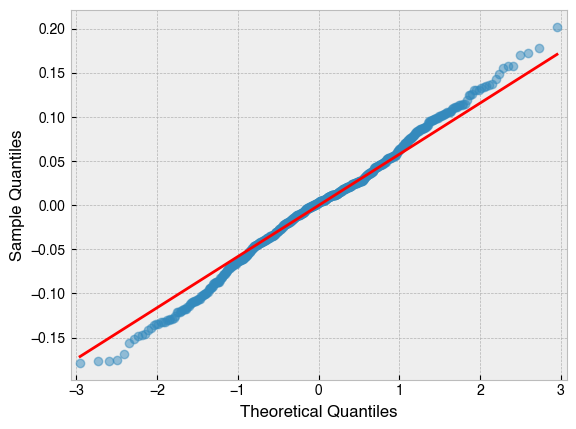

In [11]:
# from statsmodels.stats.diagnostic import het_white
# from statsmodels.stats.outliers_influence import OLSInfluence as olsi
# het_white(reswt.resid,X)
# res.get_robustcov_results(cov_type='HC0').pvalues
# studentized_residuals = olsi(reswt).resid_studentized
# leverage_pts = olsi(reswt).hat_matrix_diag
# cook_dist = olsi(reswt).cooks_distance

# sm.graphics.influence_plot(reswt, alpha  = 1e-6, criterion="cooks", plot_alpha=0.5)
# k = 61; x = np.floor(np.sqrt(2*k+0.25)-0.5).astype('int')+1; y = int(k - 0.5*x*(x-1)); print(x, y)
# sns.residplot(x=X, y=emp_dist, lowess=True, color='grey'); 
# plt.plot(fit_dist,reswt.resid,'ko',alpha=0.3); plt.plot(fit_dist,res.resid,'bx',alpha=0.3)
# sm.OLS(emp_dist/fit_dist, fit_dist).fit().summary()
# plt.plot(emp_dist/fit_dist,fit_dist,'ko',alpha=0.3); 
# plt.plot(fit_dist,emp_dist/fit_dist-np.mean(emp_dist/fit_dist),'ko'); plt.axhline(np.mean(emp_dist/fit_dist-np.mean(emp_dist/fit_dist)),color='grey'); plt.title(r'$c=0$'); plt.axhline(-4*np.std(emp_dist/fit_dist),color='grey',ls='--'); plt.xlabel('fit dist'); plt.ylabel('emp dist/fit dist')
# plt.plot(fit_dist,emp_dist/fit_dist-np.mean(emp_dist/fit_dist),'ko'); plt.axhline(np.mean(emp_dist/fit_dist-np.mean(emp_dist/fit_dist)),color='grey'); plt.title(r'$c=0$'); plt.axhline(-3*np.std(emp_dist/fit_dist),color='grey',ls='--'); plt.xlabel('fit dist'); plt.ylabel('emp dist/fit dist')
# plt.hist(emp_dist/fit_dist-np.mean(emp_dist/fit_dist),15,color='grey'); plt.axvline(-4*np.std(emp_dist/fit_dist),color='grey',ls='--')
# np.where(emp_dist/fit_dist-np.mean(emp_dist/fit_dist)<-3*np.std(emp_dist/fit_dist))
plt.figure(dpi=200)
sm.qqplot(np.log(emp_dist/fit_dist)-np.mean(np.log(emp_dist/fit_dist)),line='q',alpha=0.5); 
plt.savefig('/Users/vivaswatshastry/Documents/feems_ms/supfigs/qq_nolre.pdf')

# sm.qqplot(np.log(emp_dist/fit_dist)-np.mean(np.log(emp_dist/fit_dist)),loc=0,scale=np.std(np.log(emp_dist/fit_dist)),line='q',alpha=0.5); plt.title(r'$c=0.5$');

# plt.hist(np.log(emp_dist/fit_dist)-np.mean(np.log(emp_dist/fit_dist)),15,color='grey'); plt.axvline(-4*np.std(np.log(emp_dist/fit_dist)),color='grey',ls='--')

# sp.stats.norm.cdf(np.min(emp_dist/fit_dist-np.mean(emp_dist/fit_dist)),np.mean(emp_dist/fit_dist-np.mean(emp_dist/fit_dist)),np.std(emp_dist/fit_dist))

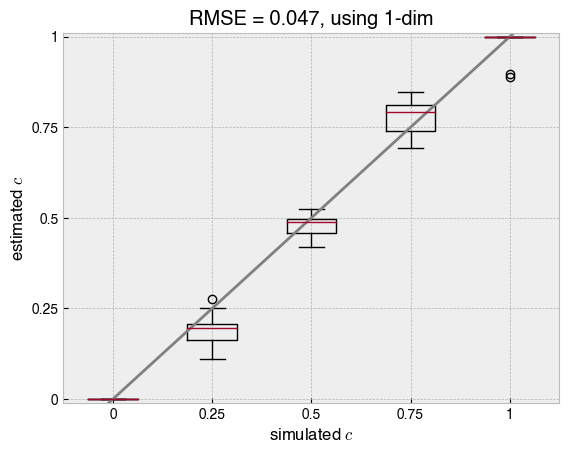

In [269]:
# plt.boxplot(estcR2mat); plt.xticks([1,2,3,4,5],['0','0.25','0.5','0.75','1']); plt.xlabel(r'simulated $c$'); plt.ylabel(r'estimated $c$'); plt.ylim((-0.01,1.01)); plt.title(r'RMSE = %.3f, joint optim w/ $L^{-1} M L^{-1,T}$'%np.round(np.sqrt(np.mean((estcR2mat-np.array([0,0.25,0.5,0.75,1]))**2)),3)); plt.yticks(np.linspace(0,1,5),labels=['0','0.25','0.5','0.75','1']); plt.show() #plt.axline((1,0),slope=0.25,color='grey'); 
plt.boxplot(estcllmat); plt.xticks([1,2,3,4,5],['0','0.25','0.5','0.75','1']); plt.xlabel(r'simulated $c$'); plt.ylabel(r'estimated $c$'); plt.ylim((-0.01,1.01)); plt.title(r'RMSE = {}, using 1-dim'.format(np.round(np.sqrt(np.mean((estcllmat-np.array([0,0.25,0.5,0.75,1]))**2)),3))); plt.yticks(np.linspace(0,1,5),labels=['0','0.25','0.5','0.75','1']); plt.axline((1,0),slope=0.25,color='grey'); 
# plt.boxplot(estcllmat); plt.xticks([1,2,3,4,5],['0','0.25','0.5','0.75','1']); plt.xlabel(r'simulated $c$'); plt.ylabel('p-value'); plt.axhline(1e-4,color='grey',ls='--'); plt.semilogy(); plt.title('top outlier edge')
# np.sum(estcllmat[:,0]<5e-3)
# plt.boxplot(estcllmat); plt.xticks([1,2,3,4,5],['0','0.25','0.5','0.75','1']); plt.xlabel(r'simulated $c$'); plt.ylabel('LL(correct) - LL(wrong)'); plt.axhline(1.,color='grey',ls='--'); 

# df = pd.DataFrame(np.random.rand(32,5), columns=[0,0.25,0.5,0.75,1])
# df['E'] = [r'joint optim, RMSE$ = 0.19$']*16+[r'stepwise optim, RMSE$ = 0.04$']*16
# df.iloc[:16,:5] = estcR2mat
# df.iloc[16:,:5] = estcllmat
# sns.violinplot(df.melt(id_vars=['E'], value_vars=[0,0.25,0.5,0.75,1]), cut=0, inner='box',x='variable', y='value', hue='E', palette='Set2'); plt.xlabel(r'simulated $c$'); plt.legend(loc='upper left'); plt.ylabel(r'estimated $c$'); plt.yticks(np.linspace(0,1,5),labels=['0','0.25','0.5','0.75','1']); plt.show()

### Changing the cross-validation scheme to optimize for genetic distance instead of allele frequencies

In [1279]:
# lamb_grid = np.geomspace(1e-2,1e2,10,endpoint=True)[::-1]
## for 5-fold, 10-fold and n-fold: 19s for both 
# cv_err = run_cv(sp_graph, lamb_grid, n_folds=5, factr=1e10, mode='distances')
# mean_cv_err = np.mean(cv_err, axis=0)
# cv_err = run_cv(sp_graph, lamb_grid, n_folds=10, factr=1e10, mode='distances')
# mean_cv_err10 = np.mean(cv_err, axis=0)
# cv_err = run_cv(sp_graph, lamb_grid, factr=1e10, mode='distances')
# mean_cv_errn = np.mean(cv_err, axis=0)

# plt.plot(lamb_grid, mean_cv_err, '-ko', label='5-fold', alpha=0.3); plt.axvline(lamb_grid[np.argmin(mean_cv_err)], color='orange', ls='--', alpha=0.3)
# plt.plot(lamb_grid, mean_cv_err10, '-ko', label='10-fold', alpha=0.6); plt.axvline(lamb_grid[np.argmin(mean_cv_err10)], color='orange', ls='--', alpha=0.6) 
# plt.plot(lamb_grid, mean_cv_errn, '-ko', label='n-fold', alpha=0.9); plt.axvline(lamb_grid[np.argmin(mean_cv_errn)], color='orange', ls='--', alpha=0.9) 
# plt.xlabel(r'$\lambda$'); plt.ylabel('CV error'); plt.legend(); plt.semilogx(); plt.title('On frequencies')

# plt.plot(lamb_grid, mean_cv_err, '-bo', label='5-fold', alpha=0.3); plt.axvline(lamb_grid[np.argmin(mean_cv_err)], color='orange', ls='--', alpha=0.3)
# plt.plot(lamb_grid, mean_cv_err10, '-bo', label='10-fold', alpha=0.6); plt.axvline(lamb_grid[np.argmin(mean_cv_err10)], color='orange', ls='--', alpha=0.6) 
# plt.plot(lamb_grid, mean_cv_errn, '-bo', label='n-fold', alpha=0.9); plt.axvline(lamb_grid[np.argmin(mean_cv_errn)], color='orange', ls='--', alpha=0.9) 
# plt.xlabel(r'$\lambda$'); plt.ylabel('CV error'); plt.legend(); plt.semilogx(); plt.title('On distances')

# plt.plot(lamb_grid,np.mean(cvq_err,axis=(0,1)),'k-o',label=r'$\lambda_w$'); plt.xlabel('values'); plt.ylabel('LOO CV error'); plt.plot(lamb_grid,np.mean(cvq_err,axis=(0,2)),'-o',color='grey',label=r'$\lambda_q$'); plt.semilogx(); plt.legend(); 

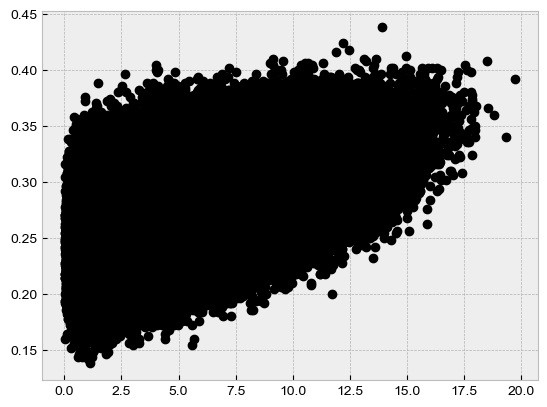

In [101]:
# print(test_ids)
# plt.imshow(fit_cov-fit_cov1); plt.colorbar()
# fit_dist_tr = fit_dist1[np.ix_(train_ids, train_ids)].ravel()
# emp_dist_tr = emp_dist1[np.ix_(train_ids, train_ids)].ravel()
# mu, beta = sp.stats.linregress(fit_dist_tr, emp_dist_tr)[0:2]
# mu, beta = np.polyfit(fit_dist_tr, emp_dist_tr, deg=1)
# from feems.utils import pairwise_PCA_distances

In [493]:
# def comp_fst_mat(genotypes, n_inds, n_demes):
#     """Computes an Fst distance matrix from a sample
#     genotype matrix and set of sub-population ids
#     """
#     n_snps = genotypes.shape[1]
#     acs = np.empty((n_demes, n_snps, 2))
    
#     # compute allele counts
#     for i in range(n_demes):
#         Gi = genotypes[np.arange(i*n_inds,(i+1)*n_inds), :]
#         acs[i, :, 0] = np.sum(Gi, axis=0)
#         acs[i, :, 1] = (2 * Gi.shape[0]) - np.sum(Gi, axis=0) 
    
#     # compute Fst matrix
#     Fst = np.empty((n_demes, n_demes))
#     for i in range(n_demes):
#         for j in range(n_demes):
#             Fst[i, j] = np.sum(allel.mean_pairwise_difference_between(acs[i, :, :].astype(np.int32), acs[j, :, :].astype(np.int32)))/n_snps

#     for i in range(n_demes):
#         Fst[i, i] = np.sum(allel.mean_pairwise_difference(acs[i, :, :].astype(np.int32)))/n_snps
#     return(Fst)

# Fst = comp_fst_mat(gen_test_36_adm,20,36)
# acs1 = np.empty((1500,2))
# acs1[:, 0] = np.sum(gen_test_36_adm[np.arange(0,20),:], axis=0)
# acs1[:, 1] = 2*gen_test_36_adm[np.arange(0,20),:].shape[0] - np.sum(gen_test_36_adm[np.arange(0,20),:], axis=0)

# acs2 = np.empty((1500,2))
# acs2[:, 0] = np.sum(gen_test_36_adm[np.arange(20,40),:], axis=0)
# acs2[:, 1] = 2*gen_test_36_adm[np.arange(20,40),:].shape[0] - np.sum(gen_test_36_adm[np.arange(20,40),:], axis=0)

# np.sum(allel.mean_pairwise_difference_between(acs1, acs2))/1500
# allel.average_hudson_fst(acs1, acs2, blen=500)

# plt.hist(np.ravel(Fst))
# plt.imshow(Fst,cmap='RdBu_r'); plt.colorbar()

array([[ 0., 40.],
       [15., 25.],
       [ 2., 38.],
       ...,
       [ 0., 40.],
       [ 4., 36.],
       [ 6., 34.]])